# Oscilloscope Analaysis for Lab 28

#### Header info

In [210]:
#Import needed libraries
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import csv
import os,platform
from scipy.optimize import curve_fit
import scipy
from scipy.fft import fft, rfft, irfft,ifft,fftfreq
#"check git"
#Read in the runlist and save as dataframe
Runlist_old= pd.read_table("./Runlist.tsv")
Runlist_old["RN"]=pd.to_numeric(Runlist_old["RN"])

#varible for determining the lab pc or other pc, Check if windows or not, then try to grab pc name
pcname=""
if platform.system() == "Windows":
    pcname=platform.uname().node
else:
    try:
        pcname=os.uname()[1]
    except:
        print("Issue with finding pc name")

env_var_wavefromloc ="" #varible for location of waveform data. 
data_dir_mod_old="" #varible for small difference in storage managment between pc 1 and 2
if pcname=='PHYS-PSB02802': #Lab pc 2, (Labview pc)
    env_var_wavefromloc ="A:/DATA/waveforms/"
    env_var_waveformloc_old="C:/Users/KK_Lab28_1/Documents/Waveforms/"
    data_dir_mod_old=""

elif pcname=="PHYS-PSB02801": #Lab pc 1, (solidworks pc)
    env_var_wavefromloc ="data/waveforms/" #This is true for Jason's work atm (June 10th) Needs Updateing to global or user friendly verison
    data_dir_mod_old="/"


def ReadRunlist(filename="C:/Users/jasonbane/Desktop/nexo_code/Run Data (GUI v1)/RunList.csv"):
    return pd.read_csv(filename,index_col=False)


global Runlist_DF
Runlist_DF = ReadRunlist()
Runlist_DF["RN"]=Runlist_DF["Run No."]

number_cols=["Anode V.","Anode Grid V.","Cathode V.","Cathode Grid V.","Drift Length"]


Runlist_DF[number_cols] = Runlist_DF[number_cols].apply(pd.to_numeric)
#Runlist_DF[number_cols] = pd.to_numeric(Runlist_DF[number_cols])

Runlist_DF["Extraction Distance"] = 1.83
Runlist_DF["Collection Distance"] = 1.83
Runlist_DF["Drift Length Error"] = 0.15

Runlist_DF["Drift Field"] = (Runlist_DF["Cathode Grid V."] - Runlist_DF["Anode Grid V."])/(Runlist_DF["Drift Length"]/10.0)
Runlist_DF["Extraction Field"] = (Runlist_DF["Cathode V."] - Runlist_DF["Cathode Grid V."])/(Runlist_DF["Extraction Distance"]/10.0)
Runlist_DF["Collection Field"] = (Runlist_DF["Anode V."] - Runlist_DF["Anode Grid V."])/(Runlist_DF["Collection Distance"]/10.0)




def GetRunInfo(runnumber, old=False):
    global Runlist_DF
    if old:
        print("not set up yet")
        return -1

    return Runlist_DF.query('`Run No.`== %f'%(runnumber))




In [391]:
class Run:

    def __init__(self, RI):
        """
        Initialize the Run class with the following attributes:
        :param cathode: The voltage or configuration of the cathode
        :param drift_length: The drift length in the detector (e.g., in mm)
        :param anode_delay: The delay associated with the anode (e.g., in µs)
        """

        self.RunNumber = RI["Run No."]
        self.Date = RI["Date"]
        self.Configuration=RI["Configuration No."]
        self.GridNo=RI["Grid No."]
        self.RunType=RI["Run Type"]
        self.AnodeBias=RI["Anode V."]
        self.AnodeGridBias=RI["Anode Grid V."]
        self.CathodeBias=RI["Cathode V."]
        self.CathodeGridBias=RI["Cathode Grid V."]
        self.LaserCurrent=RI["Laser Current"]
        self.LaserFreq=RI["Laser Freq."]
        self.Media=RI["Media"]
        self.Pressure=RI["Target Pressure"]
        self.Temp=np.mean([RI["RTD 2"],RI["RTD 3"],RI["RTD 1"]])
        self.DriftLength=RI["Drift Length"]
        self.Notes=RI["Notes"]

        
        # Date information to seleect the correct distance

        self.ExtractionDistance=RI["Extraction Distance"]
        self.CollectionDistance=RI["Collection Distance"]
        self.DriftLengthError  =RI["Drift Length Error"]

        self.DriftField = ( RI["Cathode Grid V."] -  RI["Anode Grid V."])/( RI["Drift Length"]/10.0)
        self.ExtractionField = ( RI["Cathode V."] -  RI["Cathode Grid V."])/( RI["Extraction Distance"]/10.0)
        self.collectionField = ( RI["Anode V."] -  RI["Anode Grid V."])/( RI["Collection Distance"]/10.0)


        # Analyzed results

        self.CathodeDelay=0
        self.AnodeDelay=0
        self.DriftTime=0
        self.NumDensity=0


500.0

## Functions 

In [3]:


#def grab_waveform_avg(waveform_path):
if 1==1:
    Runs=[]

    if 1==1:
        #print(waveform_path)
        dirlist = glob.glob(waveform_path+"*")
        #print(dirlist)
        for  dir in dirlist:
            dir = dir.replace("\\","/")
            subname= dir.replace(waveform_path,"")
            delim="-"
            name_sep= subname.split(delim)
            
            subname=subname.replace("\\","")
            subname=subname.replace(str(waveform_date),"")
            subname=subname.replace("%sL"%(delim),"L")
                 
            if "noise" in dir:
                LaserCur=0
                Voltags=[0,0,0]
                        
            key="L"
            item =[ i for i in name_sep if i.find(key) >= 0]
            
            result=[ i.replace(key,"") for i in item ]
            LaserCur=result[0] if len(result)>0  else 0

            key="C"
            item =[ i for i in name_sep if i.find(key) >= 0]
            result=[ i.replace(key,"") for i in item ]
            CathPot=  result[0] if len(result)>0  else 0
            print(subname,result)

            key="G"
            item =[ i for i in name_sep if i.find(key) >= 0]
            result=[ i.replace(key,"") for i in item ]
            GridPot=  result[0] if len(result)>0  else 0

            key="A"
            item =[ i for i in name_sep if i.find(key) >= 0]
            result=[ i.replace(key,"") for i in item ]
            AnodePot=  result[0] if len(result)>0  else 0

            #print("check" ,spec_loc,Apos_end)
            #print(stringtest[:Apos_end])
            #if AnodePos

            Voltags=[CathPot,GridPot,AnodePot]
          

            #Build up file name from the base name and path
            subname=subname.replace("-n","n")
            #print(waveform_path)
            file_base=waveform_path+"/"+str(waveform_date)+delim +subname
            if subname.find("vac_uv")>=0:
                continue
            #print(file_base)
            file_list= glob.glob(file_base+"/*.csv")

            #print("list\n",file_list)
            #prepare list for each channel for every waveform
            waveforms=[]
            ChAs=[] 
            ChBs=[]
            ChCs=[]
            Times=[]
            #print(file_base)
            if len(file_list)<0:
                print("No files found")
                break
        #        return 0

            #Loop through each file(waveform) 
            print("Number of waveforms: ", len(file_list))
            for file in file_list:
                #print("/t",file)
                waveform=pd.read_csv(file,skiprows=[1,2])#Read in the csv info into datafram
                
                #Grab each column and build 2D array with time steps for each channel then appended through each waveform
                Times.append(np.array(waveform["Time"]))
                ChAs.append(np.array(waveform["Channel A"]))
                ChBs.append(np.array(waveform["Channel B"]))
                ChCs.append(np.array(waveform["Channel C"]))
                

                            
            #average each channel
            Time=np.average(Times, axis=0)
            ChA=np.average(ChAs, axis=0)*1000
            ChB=np.average(ChBs, axis=0)
            ChC=np.average(ChCs, axis=0)

            waveform_dict={}
            waveform_dict["Time"]=Time
            waveform_dict["Pickoff"]=ChA
            waveform_dict["PreAmp"]=ChB
            waveform_dict["Shaper"]=ChC

            waveform_dict["LaserCur"]=LaserCur
            waveform_dict["Cathode"]=int(Voltags[0])
            waveform_dict["Grid"]   =int(Voltags[1])
            waveform_dict["Anode"]  =int(Voltags[2])
            waveform_dict["Info"]   =name_sep[-2]+"-" +name_sep[-1]
 
        # print(waveform_dict["LaserCur"])
            Runs.append(waveform_dict)
        print(len(Runs))
    #    return waveform_dict


#        return Runs



NameError: name 'waveform_path' is not defined

In [ ]:
waveform_date=20231110
waveform_path="%s%s"%(env_var_waveformloc_old,str(waveform_date))

Runs= grab_waveform_avg(waveform_path)


C:/Users/KK_Lab28_1/Documents/Waveforms/20231110
[]
0


In [ ]:
print(waveform_path[-1])


glob.glob("C:/Users/KK_Lab28_1/Documents/Waveforms/20231110*")

0


['C:/Users/KK_Lab28_1/Documents/Waveforms\\20231110-L23-C200-G0-A0-anode',
 'C:/Users/KK_Lab28_1/Documents/Waveforms\\20231110-L23-C200-G0-A0-cathode',
 'C:/Users/KK_Lab28_1/Documents/Waveforms\\20231110-L23-C200-G0-A0-grid',
 'C:/Users/KK_Lab28_1/Documents/Waveforms\\20231110-L24-C300-G0-A0-anode',
 'C:/Users/KK_Lab28_1/Documents/Waveforms\\20231110-L25-C1000-G0-A100-anode',
 'C:/Users/KK_Lab28_1/Documents/Waveforms\\20231110-L25-C500-G0-A100-anode',
 'C:/Users/KK_Lab28_1/Documents/Waveforms\\20231110-L26-C250-G0-A100-anode',
 'C:/Users/KK_Lab28_1/Documents/Waveforms\\20231110-noise']

# Analysis

# July 10th data

## Run 1 = vac

Text(0.5, 1.0, 'Vac signal on 20240711')

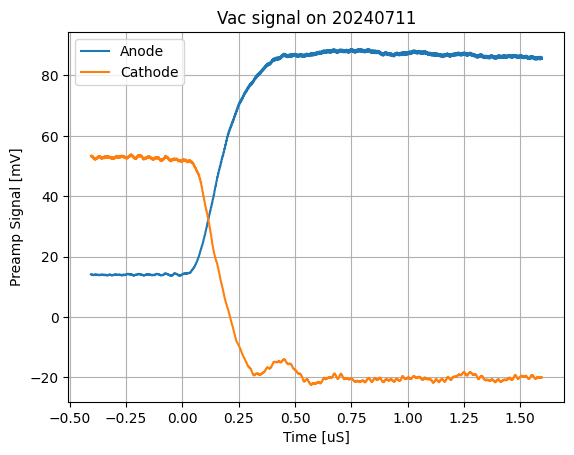

In [ ]:
wafeform_path="/Users/KK_Lab28_1/Documents/Waveforms/" # Path for data on July 7th

waveform_date="240710"
runnumber="00001"

waveform_dir=wafeform_path+waveform_date+"_"+runnumber
waveform_wavenumber="0001"
waveform_filename=waveform_date+"_"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])
DF["Avg UV"]=DF["Avg UV"]*1000 # Change from V to mV


plt.errorbar(x=DF["Time"],y=DF["Avg Anode"], label="Anode")
plt.errorbar(x=DF["Time"],y=DF["Avg UV"], label="Cathode")

plt.xlabel("Time [uS]")
plt.ylabel("Preamp Signal [mV]")
plt.grid()
plt.legend()
plt.title("Vac signal on 20240711")

Text(0.5, 1.0, 'Vac signal on 20240711')

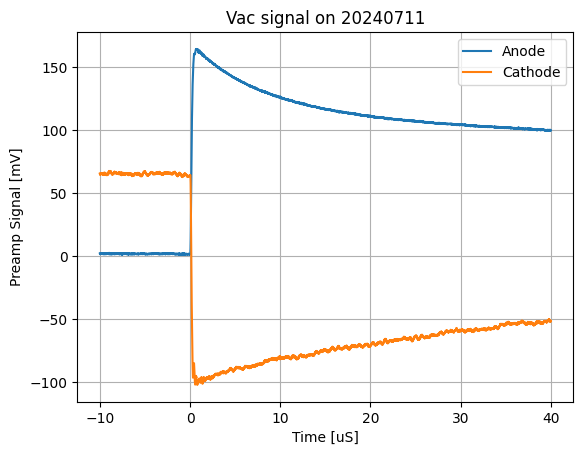

In [ ]:
wafeform_path="/Users/KK_Lab28_1/Documents/Waveforms/" # Path for data on July 7th

waveform_date="240710"
runnumber="00001"

waveform_dir=wafeform_path+waveform_date+"_"+runnumber
waveform_wavenumber="1"
waveform_filename=waveform_date+"_"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])
DF["Avg UV"]=DF["Avg UV"]*1000 # Change from V to mV


plt.errorbar(x=DF["Time"],y=DF["Avg Anode"], label="Anode")
plt.errorbar(x=DF["Time"],y=DF["Avg UV"], label="Cathode")

plt.xlabel("Time [uS]")
plt.ylabel("Preamp Signal [mV]")
plt.grid()
plt.legend()
plt.title("Vac signal on 20240711")

## Run 3

Text(0.5, 1.0, 'Vac signal on 20240711')

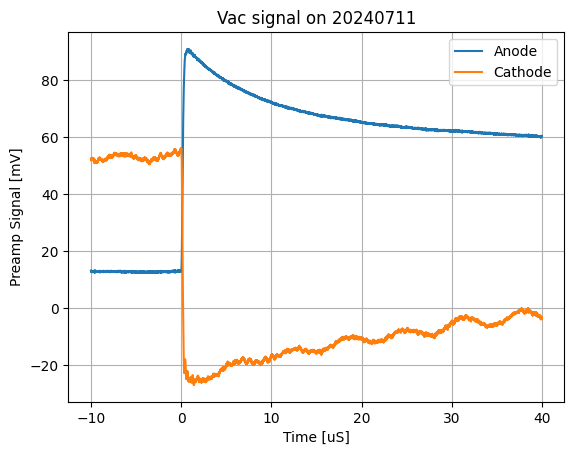

In [ ]:
wafeform_path="/Users/KK_Lab28_1/Documents/Waveforms/" # Path for data on July 7th

waveform_date="240710"
runnumber="00003"

waveform_dir=wafeform_path+waveform_date+"_"+runnumber
waveform_wavenumber="1"
waveform_filename=waveform_date+"_"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])
DF["Avg UV"]=DF["Avg UV"]*1000 # Change from V to mV


plt.errorbar(x=DF["Time"],y=DF["Avg Anode"], label="Anode")
plt.errorbar(x=DF["Time"],y=DF["Avg UV"], label="Cathode")

plt.xlabel("Time [uS]")
plt.ylabel("Preamp Signal [mV]")
plt.grid()
plt.legend()
plt.title("Vac signal on 20240711")

## Run 4

Text(0.5, 1.0, 'Vac signal on 20240711')

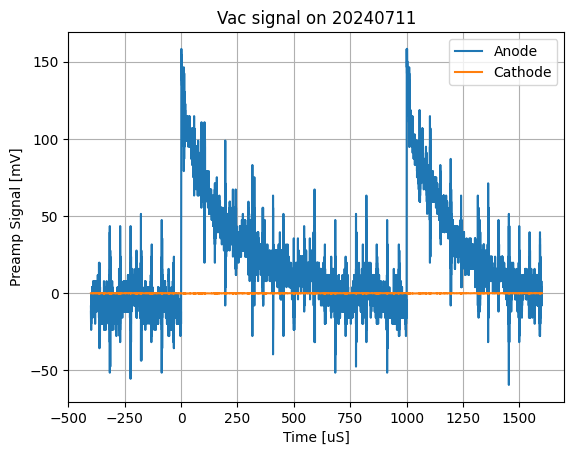

In [4]:
wafeform_path="/Users/KK_Lab28_1/Documents/Waveforms/" # Path for data on July 7th

waveform_date="240710"
runnumber="00004"

waveform_dir=wafeform_path+waveform_date+"_"+runnumber
waveform_wavenumber="2"
waveform_filename=waveform_date+"_"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])
DF["Avg UV"]=DF["Avg UV"]*1000 # Change from V to mV
DF["Time"]=DF["Time"]*1000 # Change from mS to uS


plt.errorbar(x=DF["Time"],y=DF["Channel Anode"], label="Anode")
plt.errorbar(x=DF["Time"],y=DF["Channel UV"], label="Cathode")

plt.xlabel("Time [uS]")
plt.ylabel("Preamp Signal [mV]")
plt.grid()
plt.legend()
plt.title("Vac signal on 20240711")

In [3]:
os.path.exists

<function genericpath.exists(path)>

# Grabbing data form early aug

Text(0.5, 1.0, 'Gas Signal on 20240801')

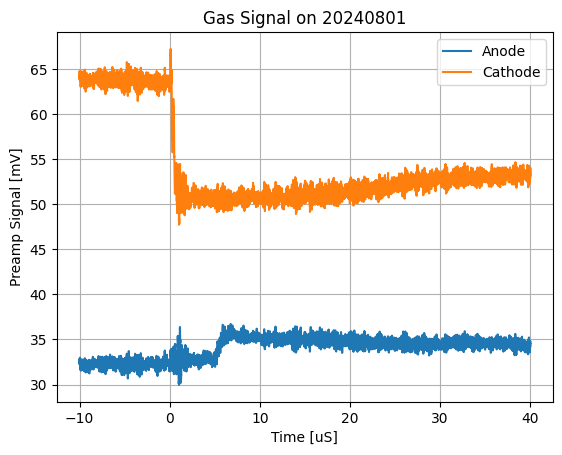

In [26]:
#wafeform_path="/Users/KK_Lab28_1/Documents/Waveforms/" # Path for data on July 7th
wafeform_path="A:/DATA/waveforms/"
waveform_date="20240801"
runnumber="00029"


waveform_dir=wafeform_path+waveform_date+"-"+runnumber
waveform_wavenumber="10"
waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])
try:
    DF["Avg UV"]=DF["Avg UV (2)"]*1000 # Change from V to mV
except:
    DF["Avg UV"]=DF["Avg UV"]*1000 # Change from V to mV
DF["Time"]=DF["Time"] # Change from mS to uS


plt.errorbar(x=DF["Time"],y=DF["Avg Anode"]*1000, label="Anode")
plt.errorbar(x=DF["Time"],y=DF["Avg UV"], label="Cathode")

plt.xlabel("Time [uS]")
plt.ylabel("Preamp Signal [mV]")
plt.grid()
plt.legend()
plt.title("Gas Signal on 20240801")
#plt.xlim(-1000,10000)

In [466]:
"%05i"%(rn)

'00030'

## Aug 1st 30-34

Run 00030   Field 312.500000  anode time Delay  6.98999986  Cathode delay  0.66200004
Run 00031   Field 437.500000  anode time Delay  6.73599986  Cathode delay  0.67200004
Run 00032   Field 562.500000  anode time Delay  6.38799987  Cathode delay  0.66400004
Run 00033   Field 687.500000  anode time Delay  6.06799988  Cathode delay  0.66400004
Run 00034   Field 812.500000  anode time Delay  5.67199989  Cathode delay  0.66000004
Drift time
[6.32799982 6.06399982 5.72399983 5.40399984 5.01199985]
[312.5, 437.5, 562.5, 687.5, 812.5]


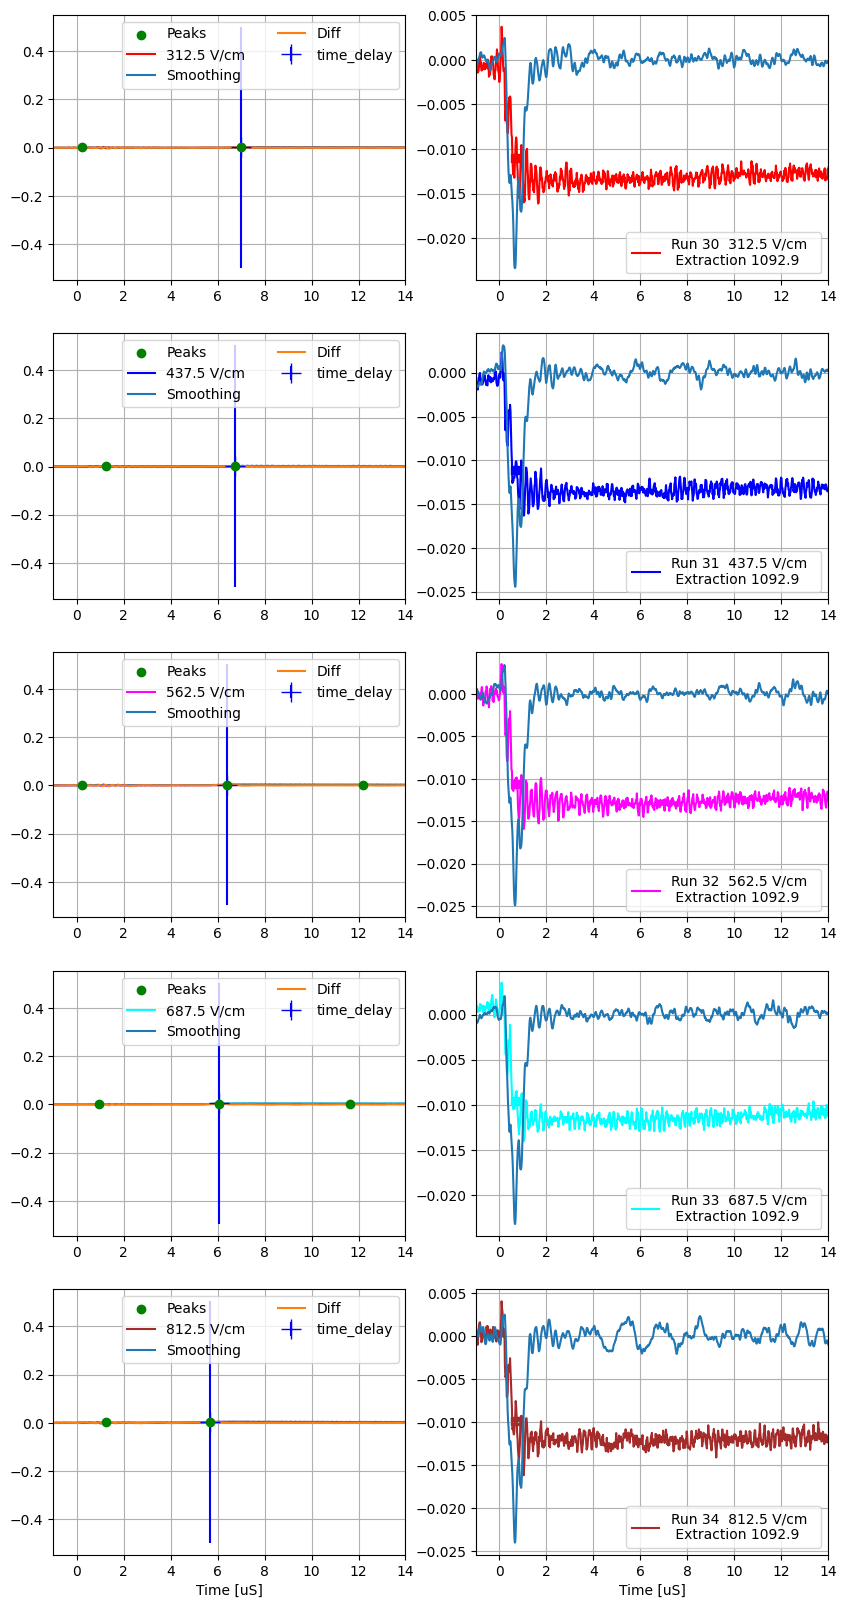

In [470]:

wafeform_path="C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/" # Path for data On left pc


runnumbers= [30,31,32,33,34]

bg_runs = ""
c=["red","blue","magenta","cyan","brown","grey","skyblue","teal","red","blue","magenta","cyan","brown","grey","skyblue"]

#chann_names=["Avg Cathode","Avg Anode"]
#chann_names=["average(Cathode)","average(Anode)"]
chann_names=["Avg UV","Avg Anode"]


anode_time_delay=[]
catho_delay=[]
drift_field_list=[]
fig, axs = plt.subplots(len(runnumbers), 2,figsize=(10,20))


for i,rn  in enumerate(runnumbers):
    
    RI = GetRunInfo(rn)
    
    waveform_date ="%i"%(RI["Date"].iloc[0])
    runnumber="%05i"%(rn)
    stepcount=5
    waveform_dir=wafeform_path+waveform_date+"/"+waveform_date+"-"+runnumber
    waveform_wavenumber="10"
    waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
    waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
    DF=pd.read_csv(waveform_fullpath,skiprows=[1])
    
    anodenorm=np.average(DF[chann_names[1]][:100])
    cathnorm=np.average(DF[chann_names[0]][:100])

    ###Background - if bg run is there

    if bg_runs != "":
        bg_runnumber="00%i"%(bg_runs[i])
        BG_dir =wafeform_path +waveform_date+"/"+waveform_date+"-"+bg_runnumber
        bg_filename=waveform_date+"-"+bg_runnumber+"_"+waveform_wavenumber
        bg_fullpath= BG_dir + "/"+bg_filename + ".csv"
        bgDF=pd.read_csv(bg_fullpath,skiprows=[1])
        bg_anodenorm=np.average(bgDF[chann_names[1]][:100])
        bg_y=(bgDF[chann_names[1]]- bg_anodenorm)*bg_norm
        
        sub = (DF[chann_names[1]] - anodenorm) - bg_y
        
        ## Plot subtracted version
        axs[i][0].errorbar(x = DF["Time"][::stepcount],y=sub[::stepcount] , color="black", label="Subtracted")

        ##BG
        axs[i][0].errorbar(x=bgDF["Time"][::stepcount*2], fmt="--",
            y=(bgDF[chann_names[1]][::stepcount*2] - bg_anodenorm)*bg_norm, 
            color="grey", label="BackGround")
        ##


    else :
        bg_y=0
        sub=(DF[chann_names[1]] - anodenorm)


    ####



    drift_field = RI["Drift Field"].iloc[0]#RI["Cathode Grid V."].iloc[0]/(9.14/10)
    extract_field=RI["Extraction Field"].iloc[0]


    #print(drift_field)



    bg_norm=1# np.max(DF[chann_names[1]][::stepcount] - anodenorm) / np.max(bgDF[chann_names[1]][::stepcount*2] - bg_anodenorm)

    axs[i][0].errorbar(x=DF["Time"][::stepcount],y=DF[chann_names[1]][::stepcount] - anodenorm, color= c[i], label="%0.1f V/cm "%(drift_field))

    stepsize=100
    diffsize=50
    diff_timestep= (DF["Time"].iloc[diffsize]-DF["Time"].iloc[0])

    xdata=np.array(DF["Time"])
    ydata= sub                 #DF[chann_names[1]]-np.average(DF[chann_names[1]][:20])
    yrolling= sub.rolling(stepsize).mean()              #ydata.rolling(stepsize).mean()
    yprime=np.array(yrolling.diff(diffsize))/(diff_timestep)

    ydata_nparray=np.array(ydata)



    local_minima_indices = argrelextrema(np.array(yprime), np.greater,order=1050)
    #local_minima_indices = argrelextrema(np.array(yprime), np.less,order=350)

    #print(local_minima_indices)
    # Get the x and y values of the local minima
    x_minima = xdata[local_minima_indices]
    y_minima = yprime[local_minima_indices]
    axs[i][0].scatter(x_minima, y_minima, color='green', label='Peaks', zorder=5)
    axs[i][0].errorbar(xdata,yrolling,label="Smoothing")
    axs[i][0].errorbar(xdata,yprime,label="Diff")
    
    ydata_minima = ydata_nparray[local_minima_indices[0][0]]
    #axs[i].scatter(x_minima[1], ydata_minima, color=c[i])
    
    time_delay_ind=0
    time_delay=xdata[np.array(local_minima_indices)[0][0]]
    while time_delay <3.5 :
        time_delay_ind=1 +time_delay_ind
        time_delay=xdata[np.array(local_minima_indices)[0][time_delay_ind]]
        if time_delay_ind > len(np.array(local_minima_indices)[0]) -1:
            print("Breaking out of while loop")
            break
        

    


    anode_time_delay.append(xdata[np.array(local_minima_indices)[0][time_delay_ind]])
    ydata_minima = ydata_nparray[local_minima_indices[0][time_delay_ind]]


    #print( x_minima[time_delay_ind], ydata_minima )
    axs[i][0].errorbar(x_minima[time_delay_ind], ydata_minima,yerr=0.5, markersize=15,
                       fmt=" ", marker="+", color="blue", label="time_delay")



    axs[i][0].grid()
    axs[i][0].legend()

##cathods

    axs[i][1].errorbar(x=DF["Time"][::stepcount],y=DF[chann_names[0]][::stepcount] - cathnorm, color= c[i]
                       , label="Run %i  %0.1f V/cm  \n Extraction %0.1f"%(rn, drift_field,extract_field))
    axs[i][1].grid()
    axs[i][1].legend()

    Time=np.array(DF["Time"])
    Cath =DF[chann_names[0]] - cathnorm
    diff = Cath.rolling(stepsize).mean().diff(diffsize)/diff_timestep

    axs[i][1].errorbar(Time,diff,label="Diff")


    cond= np.abs(diff)== np.max(np.abs(diff))
    #cond= np.abs(diff)>=5

    

    try:
        aa="a"
        #    print(Time[np.where(cond)][-1])
    except:
        print("issue with cathode timing")
    cd=Time[np.where(cond)][-1]
    cd_amp=np.array(Cath.iloc[np.where(cond)])[-1]
    catho_delay.append(cd)
    #print(cd_amp)

    axs[i][1].scatter(cd,cd_amp,marker="s",color=c[i])
    #catho_delay.append(Time[np.where(Cath == Cath_min)][0])
    #axs[i].set_xlim(-1,3)
    drift_field_list.append(drift_field)
    #print(i)
    axs[i][0].legend(ncol=2)

    axs[i][1].set_xlim(-1,14)

    axs[i][0].set_xlim(-1,14)
    #axs[i][0].set_ylim(-6,8)

    print("Run %s"%(runnumber), "  Field %f"%(drift_field) , " anode time Delay ",time_delay, " Cathode delay ", cd )

axs[i][1].set_xlabel("Time [uS]")




# print("cath")
# print(catho_delay)
# print("anode")
#print(anode_time_delay)

Drift_time=np.array(anode_time_delay)-np.array(catho_delay)

print("Drift time")
print(Drift_time)
print(drift_field_list)



    

#axs[0].set_xlabel("Time [uS]")
#axs[0].set_ylabel("Preamp Signal [mV]")

#axs[0].grid()
#axs[0][0].legend()


axs[i][0].set_xlabel("Time [uS]")
#axs[1].set_ylabel("Preamp Signal [mV]")
#axs[1].grid()
#axs[1].legend()

    #plt.title("Signal on 20240926")
#plt.xlim(-1000,10000)
drift_time_Sept18=np.array(Drift_time)
drift_field_list_Sept18=drift_field_list

## Sept 17th gas data using new script

Run 00103   Field 599.562363  anode time Delay  9.17066646  Cathode delay  1.87066667
Run 00104   Field 500.000000  anode time Delay  9.37466646  Cathode delay  1.96666666
Run 00105   Field 400.437637  anode time Delay  9.66499978  Cathode delay  2.081
Run 00106   Field 299.781182  anode time Delay  9.81799978  Cathode delay  2.15799999
Run 00107   Field 200.218818  anode time Delay  9.77599978  Cathode delay  2.072
Drift time
[7.29999979 7.4079998  7.58399978 7.65999979 7.70399978]
[599.562363238512, 500.0, 400.43763676148797, 299.781181619256, 200.21881838074398]


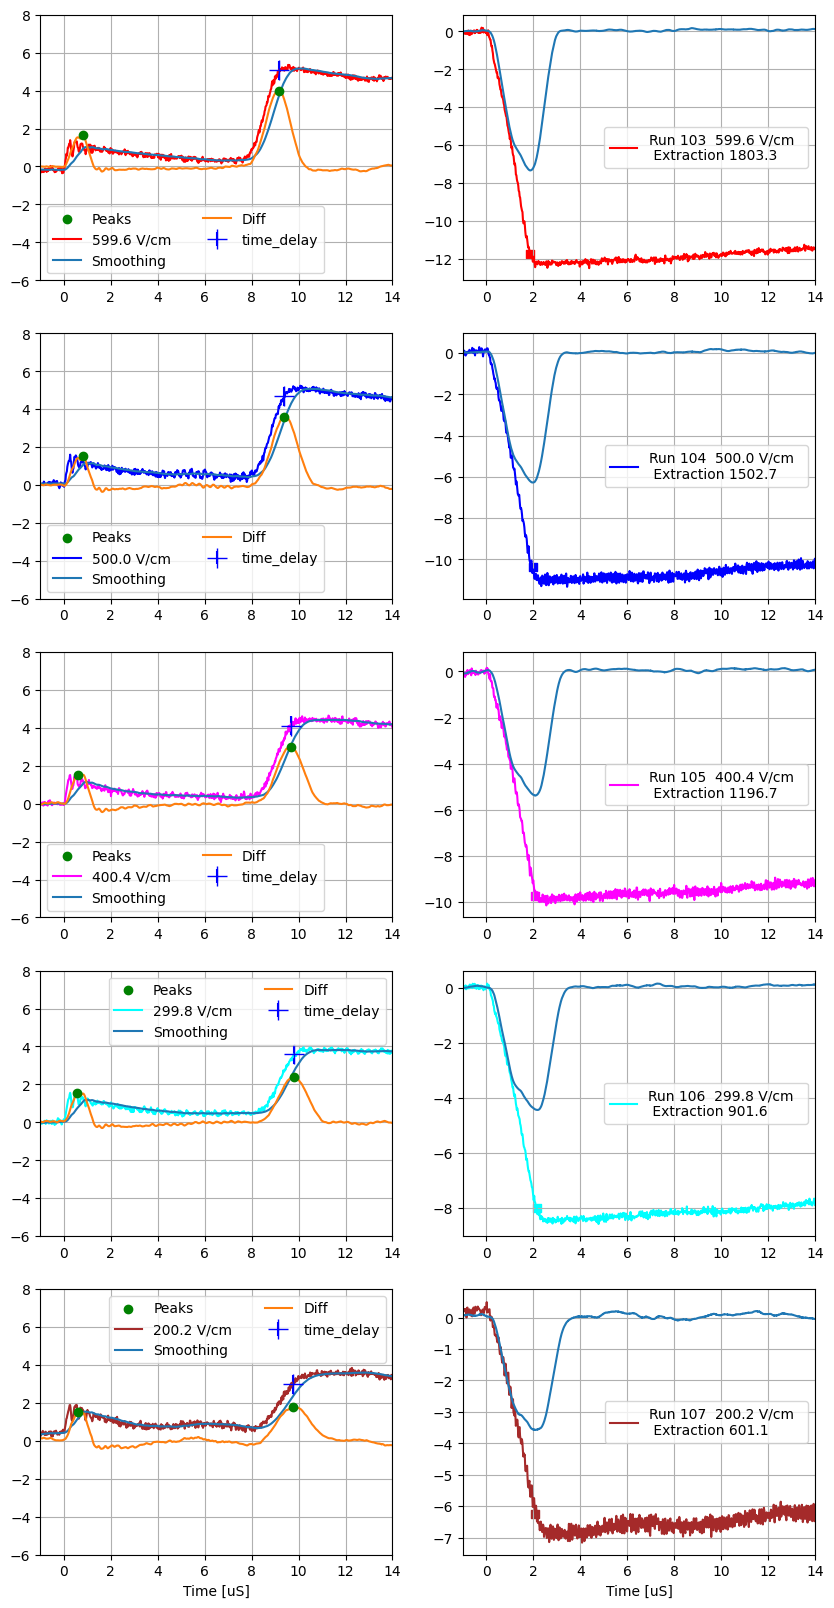

In [474]:

wafeform_path="C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/" # Path for data On left pc


runnumbers= [103,104,105,106,107]

bg_runs = ""
c=["red","blue","magenta","cyan","brown","grey","skyblue","teal","red","blue","magenta","cyan","brown","grey","skyblue"]

#chann_names=["Avg Cathode","Avg Anode"]
chann_names=["average(Cathode)","average(Anode)"]

anode_time_delay=[]
catho_delay=[]
drift_field_list=[]
fig, axs = plt.subplots(len(runnumbers), 2,figsize=(10,20))


for i,rn  in enumerate(runnumbers):
    
    RI = GetRunInfo(rn)
    
    waveform_date ="%i"%(RI["Date"].iloc[0])
    runnumber="00%i"%(rn)
    stepcount=5
    waveform_dir=wafeform_path+waveform_date+"/"+waveform_date+"-"+runnumber
    waveform_wavenumber="10"
    waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
    waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
    DF=pd.read_csv(waveform_fullpath,skiprows=[1])
    
    anodenorm=np.average(DF[chann_names[1]][:100])
    cathnorm=np.average(DF[chann_names[0]][:100])

    ###Background - if bg run is there

    if bg_runs != "":
        bg_runnumber="00%i"%(bg_runs[i])
        BG_dir =wafeform_path +waveform_date+"/"+waveform_date+"-"+bg_runnumber
        bg_filename=waveform_date+"-"+bg_runnumber+"_"+waveform_wavenumber
        bg_fullpath= BG_dir + "/"+bg_filename + ".csv"
        bgDF=pd.read_csv(bg_fullpath,skiprows=[1])
        bg_anodenorm=np.average(bgDF[chann_names[1]][:100])
        bg_y=(bgDF[chann_names[1]]- bg_anodenorm)*bg_norm
        
        sub = (DF[chann_names[1]] - anodenorm) - bg_y
        
        ## Plot subtracted version
        axs[i][0].errorbar(x = DF["Time"][::stepcount],y=sub[::stepcount] , color="black", label="Subtracted")

        ##BG
        axs[i][0].errorbar(x=bgDF["Time"][::stepcount*2], fmt="--",
            y=(bgDF[chann_names[1]][::stepcount*2] - bg_anodenorm)*bg_norm, 
            color="grey", label="BackGround")
        ##


    else :
        bg_y=0
        sub=(DF[chann_names[1]] - anodenorm)


    ####



    drift_field = RI["Drift Field"].iloc[0]#RI["Cathode Grid V."].iloc[0]/(9.14/10)
    extract_field=RI["Extraction Field"].iloc[0]


    #print(drift_field)



    bg_norm=1# np.max(DF[chann_names[1]][::stepcount] - anodenorm) / np.max(bgDF[chann_names[1]][::stepcount*2] - bg_anodenorm)

    axs[i][0].errorbar(x=DF["Time"][::stepcount],y=DF[chann_names[1]][::stepcount] - anodenorm, color= c[i], label="%0.1f V/cm "%(drift_field))

    stepsize=200
    diffsize=100
    diff_timestep= (DF["Time"].iloc[diffsize]-DF["Time"].iloc[0])

    xdata=np.array(DF["Time"])
    ydata= sub                 #DF[chann_names[1]]-np.average(DF[chann_names[1]][:20])
    yrolling= sub.rolling(stepsize).mean()              #ydata.rolling(stepsize).mean()
    yprime=np.array(yrolling.diff(diffsize))/(diff_timestep)

    ydata_nparray=np.array(ydata)



    local_minima_indices = argrelextrema(np.array(yprime), np.greater,order=1050)
    #local_minima_indices = argrelextrema(np.array(yprime), np.less,order=350)

    #print(local_minima_indices)
    # Get the x and y values of the local minima
    x_minima = xdata[local_minima_indices]
    y_minima = yprime[local_minima_indices]
    axs[i][0].scatter(x_minima, y_minima, color='green', label='Peaks', zorder=5)
    axs[i][0].errorbar(xdata,yrolling,label="Smoothing")
    axs[i][0].errorbar(xdata,yprime,label="Diff")
    
    ydata_minima = ydata_nparray[local_minima_indices[0][0]]
    #axs[i].scatter(x_minima[1], ydata_minima, color=c[i])
    
    time_delay_ind=0
    time_delay=xdata[np.array(local_minima_indices)[0][0]]
    while time_delay <3.5 :
        time_delay_ind=1 +time_delay_ind
        time_delay=xdata[np.array(local_minima_indices)[0][time_delay_ind]]
        if time_delay_ind > len(np.array(local_minima_indices)[0]) -1:
            print("Breaking out of while loop")
            break
        

    


    anode_time_delay.append(xdata[np.array(local_minima_indices)[0][time_delay_ind]])
    ydata_minima = ydata_nparray[local_minima_indices[0][time_delay_ind]]


    #print( x_minima[time_delay_ind], ydata_minima )
    axs[i][0].errorbar(x_minima[time_delay_ind], ydata_minima,yerr=0.5, markersize=15,
                       fmt=" ", marker="+", color="blue", label="time_delay")



    axs[i][0].grid()
    axs[i][0].legend()

##cathods

    axs[i][1].errorbar(x=DF["Time"][::stepcount],y=DF[chann_names[0]][::stepcount] - cathnorm, color= c[i]
                       , label="Run %i  %0.1f V/cm  \n Extraction %0.1f"%(rn, drift_field,extract_field))
    axs[i][1].grid()
    axs[i][1].legend()

    Time=np.array(DF["Time"])
    Cath =DF[chann_names[0]] - cathnorm
    diff = Cath.rolling(stepsize).mean().diff(diffsize)/diff_timestep

    axs[i][1].errorbar(Time,diff,label="Diff")


    cond= np.abs(diff)== np.max(np.abs(diff))
    #cond= np.abs(diff)>=5

    

    try:
        aa="a"
        #    print(Time[np.where(cond)][-1])
    except:
        print("issue with cathode timing")
    cd=Time[np.where(cond)][-1]
    cd_amp=np.array(Cath.iloc[np.where(cond)])[-1]
    catho_delay.append(cd)
    #print(cd_amp)

    axs[i][1].scatter(cd,cd_amp,marker="s",color=c[i])
    #catho_delay.append(Time[np.where(Cath == Cath_min)][0])
    #axs[i].set_xlim(-1,3)
    drift_field_list.append(drift_field)
    #print(i)
    axs[i][0].legend(ncol=2)

    axs[i][1].set_xlim(-1,14)

    axs[i][0].set_xlim(-1,14)
    axs[i][0].set_ylim(-6,8)

    print("Run %s"%(runnumber), "  Field %f"%(drift_field) , " anode time Delay ",time_delay, " Cathode delay ", cd )

axs[i][1].set_xlabel("Time [uS]")




# print("cath")
# print(catho_delay)
# print("anode")
#print(anode_time_delay)

Drift_time=np.array(anode_time_delay)-np.array(catho_delay)

print("Drift time")
print(Drift_time)
print(drift_field_list)



    

#axs[0].set_xlabel("Time [uS]")
#axs[0].set_ylabel("Preamp Signal [mV]")

#axs[0].grid()
#axs[0][0].legend()


axs[i][0].set_xlabel("Time [uS]")
#axs[1].set_ylabel("Preamp Signal [mV]")
#axs[1].grid()
#axs[1].legend()

    #plt.title("Signal on 20240926")
#plt.xlim(-1000,10000)
drift_time_Sept18=np.array(Drift_time)
drift_field_list_Sept18=drift_field_list

In [459]:
N_Sept18= ((25 *6894.76)/( (1.38*10**(-23))* 293)) 
N_Sept18

4.262971756442599e+25

## Electron Drift and Longitudinal Diffusion in High Pressure
Xenon-Helium Gas Mixtures
FERMILAB-PUB-19-518-ND-SCD (accepted)
DOI: 10.1088/1748-0221/14/08/P08009
arXiv:1902.05544 [physics.ins-det]

In [476]:
NEXT_2018_RedF =(np.array([5.295,10.591, 11.405,13.849, 24.44, 31.365, 39.919, 48.88, 63.137, 78.615, 92.872])/100000)/( (1.38*10**(-23))* 293) *10**(-21) 
NEXT_2018_vel = [0.088, 0.369, 0.417, 0.617, 0.82, 0.877, 0.908, 0.936, 0.999, 1.041, 1.068]  #[mm/us]
	
NEXT_2018_RedF



array([1.30954147e-05, 2.61933027e-05, 2.82064599e-05, 3.42508780e-05,
       6.04441806e-05, 7.75708562e-05, 9.87263194e-05, 1.20888361e-04,
       1.56148291e-04, 1.94427957e-04, 2.29687886e-04])

Text(0.5, 0, 'Reduced Field V/N [ Td]')

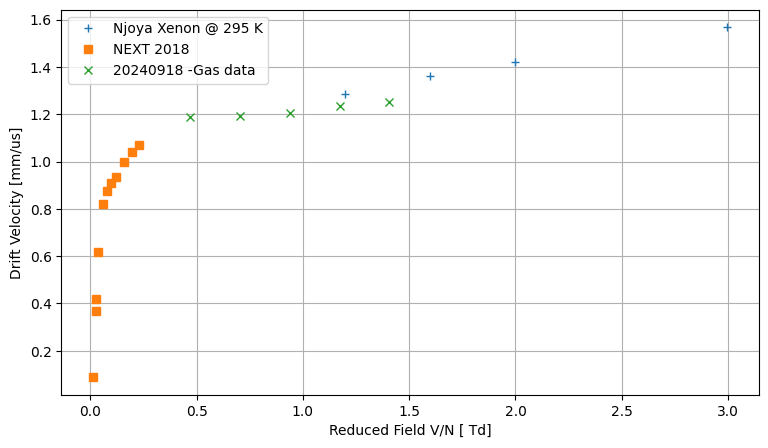

In [477]:
fig,ax= plt.subplots(1, 1, figsize=(9,5))


njyl=np.array([1.568,1.422, 1.36, 1.285])
njxl=np.array([750.98,500.98,400,300])
#njoya_x=[200*2,200*2,300*2,400*2,500*2,1000*2]

njoya_x=njxl
njoya_y=njyl
BNL_N= ((14.7 *6894.76)/( (1.38*10**(-23))* 293)) 

ax.errorbar(x=njoya_x/BNL_N*100 / 10**(-21),y=njoya_y,fmt=" ",marker="+",label="Njoya Xenon @ 295 K")

ax.errorbar(x=NEXT_2018_RedF*1000 ,y=NEXT_2018_vel,fmt=" ",marker="s",label="NEXT 2018")



ax.errorbar(x=(np.array(drift_field_list_Sept18)/N_Sept18 )*100/ 10**(-21) ,y=(9.14)/drift_time_Sept18,fmt=" " ,marker="x",label="20240918 -Gas data")
ax.grid()
ax.legend()
#ax.set_ylim(0.6,1.7)
#ax.set_xlim(0.01,1.7)

#ax.text(0.4,1.15,"%0.0f [v/cm]"%(drift_field_list_Sept18[-1]))
#ax.text(1.4,1.18,"%0.0f [v/cm]"%(drift_field_list_Sept18[0]))


ax.set_ylabel("Drift Velocity [mm/us]")
ax.set_xlabel("Reduced Field V/N [ Td]")

# Data form Sept 17

Run:  00054  Anode str:  1.951637699999992  Cathode str:  7.7283449
Run:  00062  Anode str:  1.806094299999998  Cathode str:  6.118642099999999
Run:  00063  Anode str:  1.5500383000000042  Cathode str:  4.763031699999999


Text(0.5, 1.0, 'Gas Signal on 20240917')

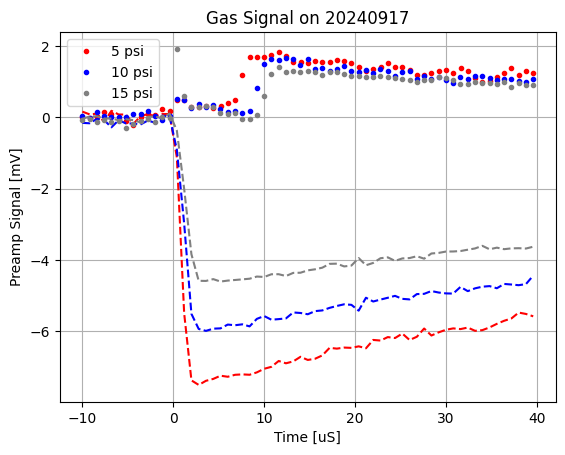

In [45]:
#wafeform_path="/Users/KK_Lab28_1/Documents/Waveforms/" # Path for data on July 7th
wafeform_path="A:/DATA/waveforms/"
waveform_date="20240917"
runnumber="00054"

stepcount=200
waveform_dir=wafeform_path+waveform_date+"-"+runnumber
waveform_wavenumber="10"
waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])



anodenorm=np.average(DF["Average Anode (2)"][:100])
cathnorm=np.average(DF["Average Cathode (2)"][:100])


plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Anode (2)"][::stepcount] - anodenorm, color= "red", fmt=".",label="5 psi")
plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Cathode (2)"][::stepcount] - cathnorm, color= "red", fmt="--",)
Anode_amp   =abs(np.average(DF["Average Anode (2)"][:100])-np.max(DF["Average Anode (2)"][2700:]))
Cathode_amp =abs(np.average(DF["Average Cathode (2)"][:100])-np.min(DF["Average Cathode (2)"]))
print("Run: ",runnumber," Anode str: ", Anode_amp, " Cathode str: ", Cathode_amp)


runnumber="00062"


waveform_dir=wafeform_path+waveform_date+"-"+runnumber
waveform_wavenumber="10"
waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])


anodenorm=np.average(DF["Average Anode (2)"][:100])
cathnorm=np.average(DF["Average Cathode (2)"][:100])

plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Anode (2)"][::stepcount] - anodenorm, color= "Blue", fmt=".",label="10 psi")
plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Cathode (2)"][::stepcount] - cathnorm, color= "Blue", fmt="--",)
Anode_amp   =abs(np.average(DF["Average Anode (2)"][:100])-np.max(DF["Average Anode (2)"][2700:]))
Cathode_amp =abs(np.average(DF["Average Cathode (2)"][:100])-np.min(DF["Average Cathode (2)"]))
print("Run: ",runnumber," Anode str: ", Anode_amp, " Cathode str: ", Cathode_amp)

runnumber="00063"


waveform_dir=wafeform_path+waveform_date+"-"+runnumber
waveform_wavenumber="10"
waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])

anodenorm=np.average(DF["Average Anode (2)"][:100])
cathnorm=np.average(DF["Average Cathode (2)"][:100])

plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Anode (2)"][0::stepcount] - anodenorm, color= "Gray", fmt=".",label="15 psi")
plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Cathode (2)"][::stepcount] - cathnorm, color= "Gray", fmt="--",)


Anode_amp   =abs(np.average(DF["Average Anode (2)"][:100])-np.max(DF["Average Anode (2)"][2700:]))
Cathode_amp =abs(np.average(DF["Average Cathode (2)"][:100])-np.min(DF["Average Cathode (2)"]))
print("Run: ",runnumber," Anode str: ", Anode_amp, " Cathode str: ", Cathode_amp)

plt.xlabel("Time [uS]")
plt.ylabel("Preamp Signal [mV]")
plt.grid()
plt.legend()
plt.title("Gas Signal on 20240917")
#plt.xlim(-1000,10000)



Text(0.5, 1.0, 'Gas Signal on 20240917')

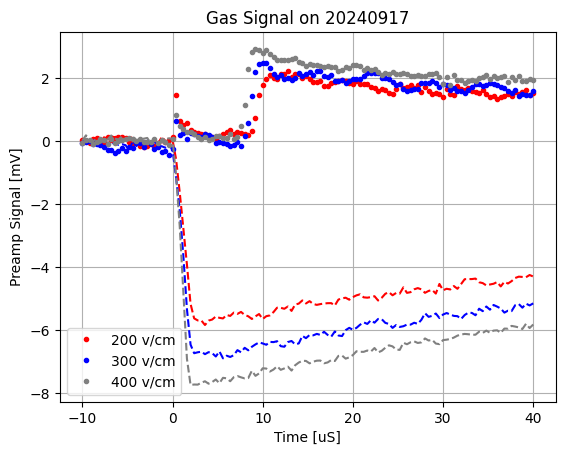

In [29]:
#wafeform_path="/Users/KK_Lab28_1/Documents/Waveforms/" # Path for data on July 7th
wafeform_path="A:/DATA/waveforms/"
waveform_date="20240917"
runnumber="00064"

stepcount=100
waveform_dir=wafeform_path+waveform_date+"-"+runnumber
waveform_wavenumber="10"
waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])



anodenorm=np.average(DF["Average Anode (2)"][:100])
cathnorm=np.average(DF["Average Cathode (2)"][:100])


plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Anode (2)"][::stepcount] - anodenorm, color= "red", fmt=".",label="200 v/cm")
plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Cathode (2)"][::stepcount] - cathnorm, color= "red", fmt="--",)



runnumber="00065"


waveform_dir=wafeform_path+waveform_date+"-"+runnumber
waveform_wavenumber="10"
waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])


anodenorm=np.average(DF["Average Anode (2)"][:100])
cathnorm=np.average(DF["Average Cathode (2)"][:100])

plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Anode (2)"][::stepcount] - anodenorm, color= "Blue", fmt=".",label="300 v/cm")
plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Cathode (2)"][::stepcount] - cathnorm, color= "Blue", fmt="--",)


runnumber="00066"


waveform_dir=wafeform_path+waveform_date+"-"+runnumber
waveform_wavenumber="10"
waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])

anodenorm=np.average(DF["Average Anode (2)"][:100])
cathnorm=np.average(DF["Average Cathode (2)"][:100])

plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Anode (2)"][0::stepcount] - anodenorm, color= "Gray", fmt=".",label="400 v/cm")
plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Cathode (2)"][::stepcount] - cathnorm, color= "Gray", fmt="--",)




plt.xlabel("Time [uS]")
plt.ylabel("Preamp Signal [mV]")
plt.grid()
plt.legend()
plt.title("Gas Signal on 20240917")
#plt.xlim(-1000,10000)

## Run55 cathode off

Text(0.5, 1.0, 'Gas Signal on 20240917')

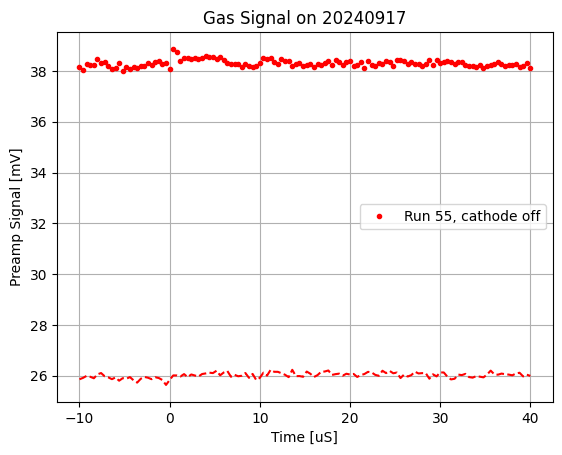

In [53]:
#wafeform_path="/Users/KK_Lab28_1/Documents/Waveforms/" # Path for data on July 7th
wafeform_path="A:/DATA/waveforms/"
waveform_date="20240917"
runnumber="00055"

stepcount=100
waveform_dir=wafeform_path+waveform_date+"-"+runnumber
waveform_wavenumber="10"
waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])



anodenorm=0#np.average(DF["Average Anode (2)"][:100])
cathnorm=-20#np.average(DF["Average Cathode (2)"][:100])


plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Anode (2)"][::stepcount] - anodenorm, color= "red", fmt=".",label="Run 55, cathode off")
plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Cathode (2)"][::stepcount] - cathnorm, color= "red", fmt="--",)



# runnumber="00065"


# waveform_dir=wafeform_path+waveform_date+"-"+runnumber
# waveform_wavenumber="10"
# waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
# waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
# DF=pd.read_csv(waveform_fullpath,skiprows=[1])


# anodenorm=np.average(DF["Average Anode (2)"][:100])
# cathnorm=np.average(DF["Average Cathode (2)"][:100])

# plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Anode (2)"][::stepcount] - anodenorm, color= "Blue", fmt=".",label="300 v/cm")
# plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Cathode (2)"][::stepcount] - cathnorm, color= "Blue", fmt="--",)


# runnumber="00066"


# waveform_dir=wafeform_path+waveform_date+"-"+runnumber
# waveform_wavenumber="10"
# waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
# waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
# DF=pd.read_csv(waveform_fullpath,skiprows=[1])

# anodenorm=np.average(DF["Average Anode (2)"][:100])
# cathnorm=np.average(DF["Average Cathode (2)"][:100])

# plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Anode (2)"][0::stepcount] - anodenorm, color= "Gray", fmt=".",label="400 v/cm")
# plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Cathode (2)"][::stepcount] - cathnorm, color= "Gray", fmt="--",)




plt.xlabel("Time [uS]")
plt.ylabel("Preamp Signal [mV]")
plt.grid()
plt.legend()
plt.title("Gas Signal on 20240917")
#plt.xlim(-1000,10000)

# Data From Sept 20th

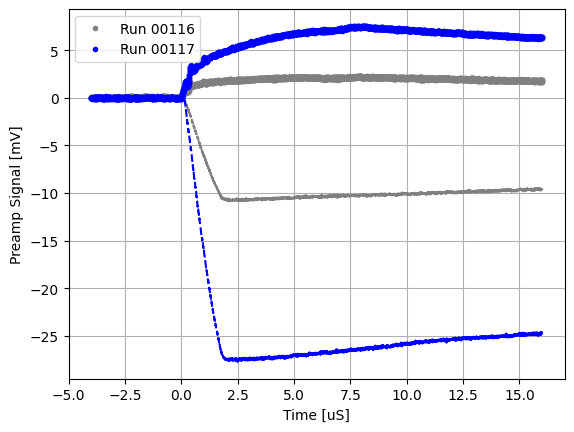

In [159]:
#wafeform_path="/Users/KK_Lab28_1/Documents/Waveforms/" # Path for data on July 7th
wafeform_path="A:/DATA/waveforms/"
wafeform_path="C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/" # Path for data On left pc

# waveform_date="20240920"
# runnumber="00115"

# stepcount=100
# waveform_dir=wafeform_path+waveform_date+"-"+runnumber
# waveform_wavenumber="10"
# waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
# waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
# DF=pd.read_csv(waveform_fullpath,skiprows=[1])



# anodenorm=np.average(DF["average(Anode)"][:100])
# cathnorm=np.average(DF["average(Cathode)"][:100])


# plt.errorbar(x=DF["Time"][::stepcount],y=DF["average(Anode)"][::stepcount] - anodenorm, color= "Gray", fmt=".",label="Run %s"%(runnumber))
# plt.errorbar(x=DF["Time"][::stepcount],y=DF["average(Cathode)"][::stepcount] - cathnorm, color= "Gray", fmt="--",)

waveform_date="20240926"
runnumber="00116"

stepcount=1
waveform_dir=wafeform_path+waveform_date+"/"+waveform_date+"-"+runnumber
waveform_wavenumber="10"
waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])



anodenorm=np.average(DF["average(Anode)"][:100])
cathnorm=np.average(DF["average(Cathode)"][:100])


plt.errorbar(x=DF["Time"][::stepcount],y=DF["average(Anode)"][::stepcount] - anodenorm, color= "Grey", fmt=".",label="Run %s"%(runnumber))
plt.errorbar(x=DF["Time"][::stepcount],y=DF["average(Cathode)"][::stepcount] - cathnorm, color= "Grey", fmt="--",)



# waveform_date="20240920"
# runnumber="00113"

# stepcount=1#00
# waveform_dir=wafeform_path+waveform_date+"-"+runnumber
# waveform_wavenumber="10"
# waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
# waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
# DF=pd.read_csv(waveform_fullpath,skiprows=[1])



# anodenorm=np.average(DF["average(Anode)"][:100])
# cathnorm=np.average(DF["average(Cathode)"][:100])


# plt.errorbar(x=DF["Time"][::stepcount],y=DF["average(Anode)"][::stepcount] - anodenorm, color= "red", fmt=".",label="Run %s"%(runnumber))
# plt.errorbar(x=DF["Time"][::stepcount],y=DF["average(Cathode)"][::stepcount] - cathnorm, color= "red", fmt="--",)


waveform_date="20240926"
runnumber="00117"

stepcount=1
waveform_dir=wafeform_path+waveform_date+"/"+waveform_date+"-"+runnumber
waveform_wavenumber="10"
waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])



anodenorm=np.average(DF["average(Anode)"][:100])
cathnorm=np.average(DF["average(Cathode)"][:100])


plt.errorbar(x=DF["Time"][::stepcount],y=DF["average(Anode)"][::stepcount] - anodenorm, color= "blue", fmt=".",label="Run %s"%(runnumber))
plt.errorbar(x=DF["Time"][::stepcount],y=DF["average(Cathode)"][::stepcount] - cathnorm, color= "blue", fmt="--",)



# runnumber="00065"


# waveform_dir=wafeform_path+waveform_date+"-"+runnumber
# waveform_wavenumber="10"
# waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
# waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
# DF=pd.read_csv(waveform_fullpath,skiprows=[1])


# anodenorm=np.average(DF["Average Anode (2)"][:100])
# cathnorm=np.average(DF["Average Cathode (2)"][:100])

# plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Anode (2)"][::stepcount] - anodenorm, color= "Blue", fmt=".",label="300 v/cm")
# plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Cathode (2)"][::stepcount] - cathnorm, color= "Blue", fmt="--",)


# runnumber="00066"


# waveform_dir=wafeform_path+waveform_date+"-"+runnumber
# waveform_wavenumber="10"
# waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
# waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
# DF=pd.read_csv(waveform_fullpath,skiprows=[1])

# anodenorm=np.average(DF["Average Anode (2)"][:100])
# cathnorm=np.average(DF["Average Cathode (2)"][:100])

# plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Anode (2)"][0::stepcount] - anodenorm, color= "Gray", fmt=".",label="400 v/cm")
# plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Cathode (2)"][::stepcount] - cathnorm, color= "Gray", fmt="--",)




plt.xlabel("Time [uS]")
plt.ylabel("Preamp Signal [mV]")
plt.grid()
plt.legend()
#plt.title()
#plt.xlim(-1000,10000)

# Sept 26th


Text(0.5, 1.0, 'Signal on 20240926')

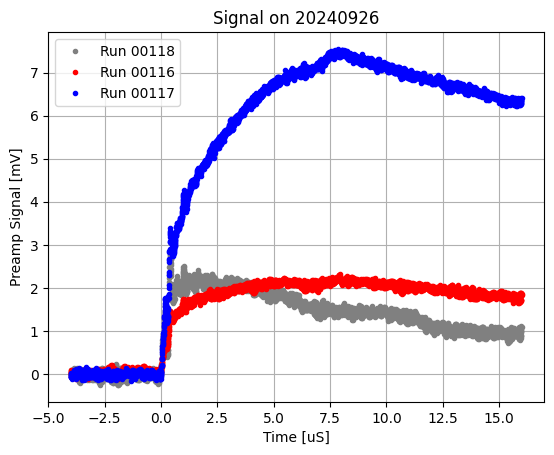

In [155]:
#wafeform_path="/Users/KK_Lab28_1/Documents/Waveforms/" # Path for data on July 7th
wafeform_path="A:/DATA/waveforms/"
wafeform_path="C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/" # Path for data On left pc

# waveform_date="20240920"
# runnumber="00115"

# stepcount=100
# waveform_dir=wafeform_path+waveform_date+"-"+runnumber
# waveform_wavenumber="10"
# waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
# waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
# DF=pd.read_csv(waveform_fullpath,skiprows=[1])



# anodenorm=np.average(DF["average(Anode)"][:100])
# cathnorm=np.average(DF["average(Cathode)"][:100])


# plt.errorbar(x=DF["Time"][::stepcount],y=DF["average(Anode)"][::stepcount] - anodenorm, color= "Gray", fmt=".",label="Run %s"%(runnumber))
# plt.errorbar(x=DF["Time"][::stepcount],y=DF["average(Cathode)"][::stepcount] - cathnorm, color= "Gray", fmt="--",)

waveform_date="20240926"
runnumber="00118"

stepcount=1
waveform_dir=wafeform_path+"/"+waveform_date+"/"+waveform_date+"-"+runnumber
waveform_wavenumber="10"
waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])



anodenorm=np.average(DF["average(Anode)"][:100])
cathnorm=np.average(DF["average(Cathode)"][:100])


plt.errorbar(x=DF["Time"][::stepcount],y=DF["average(Anode)"][::stepcount] - anodenorm, color= "Grey", fmt=".",label="Run %s"%(runnumber))
#plt.errorbar(x=DF["Time"][::stepcount],y=DF["average(Cathode)"][::stepcount] - cathnorm, color= "Grey", fmt="--",)



waveform_date="20240926"
runnumber="00116"

stepcount=1
waveform_dir=wafeform_path+"/"+waveform_date+"/"+waveform_date+"-"+runnumber
waveform_wavenumber="10"
waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])



anodenorm=np.average(DF["average(Anode)"][:100])
cathnorm=np.average(DF["average(Cathode)"][:100])


plt.errorbar(x=DF["Time"][::stepcount],y=DF["average(Anode)"][::stepcount] - anodenorm, color= "red", fmt=".",label="Run %s"%(runnumber))
#plt.errorbar(x=DF["Time"][::stepcount],y=DF["average(Cathode)"][::stepcount] - cathnorm, color= "red", fmt="--",)


waveform_date="20240926"
runnumber="00117"

stepcount=1
waveform_dir=wafeform_path+"/"+waveform_date+"/"+waveform_date+"-"+runnumber
waveform_wavenumber="10"
waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])



anodenorm=np.average(DF["average(Anode)"][:100])
cathnorm=np.average(DF["average(Cathode)"][:100])


plt.errorbar(x=DF["Time"][::stepcount],y=DF["average(Anode)"][::stepcount] - anodenorm, color= "blue", fmt=".",label="Run %s"%(runnumber))
#plt.errorbar(x=DF["Time"][::stepcount],y=DF["average(Cathode)"][::stepcount] - cathnorm, color= "blue", fmt="--",)



# runnumber="00065"


# waveform_dir=wafeform_path+waveform_date+"-"+runnumber
# waveform_wavenumber="10"
# waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
# waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
# DF=pd.read_csv(waveform_fullpath,skiprows=[1])


# anodenorm=np.average(DF["Average Anode (2)"][:100])
# cathnorm=np.average(DF["Average Cathode (2)"][:100])

# plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Anode (2)"][::stepcount] - anodenorm, color= "Blue", fmt=".",label="300 v/cm")
# plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Cathode (2)"][::stepcount] - cathnorm, color= "Blue", fmt="--",)


# runnumber="00066"


# waveform_dir=wafeform_path+waveform_date+"-"+runnumber
# waveform_wavenumber="10"
# waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
# waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
# DF=pd.read_csv(waveform_fullpath,skiprows=[1])

# anodenorm=np.average(DF["Average Anode (2)"][:100])
# cathnorm=np.average(DF["Average Cathode (2)"][:100])

# plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Anode (2)"][0::stepcount] - anodenorm, color= "Gray", fmt=".",label="400 v/cm")
# plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Cathode (2)"][::stepcount] - cathnorm, color= "Gray", fmt="--",)




plt.xlabel("Time [uS]")
plt.ylabel("Preamp Signal [mV]")
plt.grid()
plt.legend()
plt.title("Signal on 20240926")
#plt.xlim(-1000,10000)

In [5]:
waveform_date="20240926"
runnumber="00116"
waveform_dir=wafeform_path+waveform_date+"-"+runnumber
waveform_wavenumber="10"
waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF116=pd.read_csv(waveform_fullpath,skiprows=[1])
waveform_date="20240926"
runnumber="00117"
waveform_dir=wafeform_path+waveform_date+"-"+runnumber
waveform_wavenumber="10"
waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF117=pd.read_csv(waveform_fullpath,skiprows=[1])
waveform_date="20240926"
runnumber="00118"
waveform_dir=wafeform_path+waveform_date+"-"+runnumber
waveform_wavenumber="10"
waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF118=pd.read_csv(waveform_fullpath,skiprows=[1])

Text(0.5, 1.0, 'Signal on 20240926')

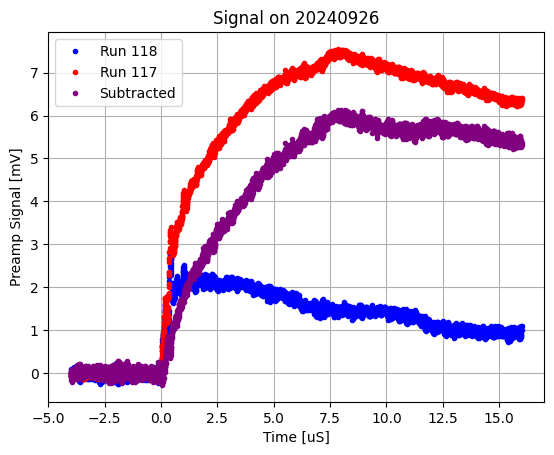

In [7]:
anodenorm118=np.average(DF118["average(Anode)"][:100])
cathnorm118 =np.average(DF118["average(Cathode)"][:100])


plt.errorbar(x=DF118["Time"][::stepcount],y=DF118["average(Anode)"][::stepcount] - anodenorm118, color= "blue", fmt=".",label="Run 118")

anodenorm117=np.average(DF117["average(Anode)"][:100])
cathnorm117= np.average(DF117["average(Cathode)"][:100])


plt.errorbar(x=DF117["Time"][::stepcount],y=DF117["average(Anode)"][::stepcount] - anodenorm117, color= "red", fmt=".",label="Run 117")

plt.errorbar(x=DF117["Time"][::stepcount],y=(DF117["average(Anode)"][::stepcount] - anodenorm117) -(DF118["average(Anode)"][::stepcount] - anodenorm118), color= "purple", fmt=".",label="Subtracted")



plt.xlabel("Time [uS]")
plt.ylabel("Preamp Signal [mV]")
plt.grid()
plt.legend()
plt.title("Signal on 20240926")
#plt.xlim(-1000,10000)

# Data analysis for LXe data from Sept 20th and 26th

0
(array([ 802, 1593, 2683, 3336, 4194, 4823], dtype=int64),)
[6.72399979]


Text(0.5, 0, 'Time [uS]')

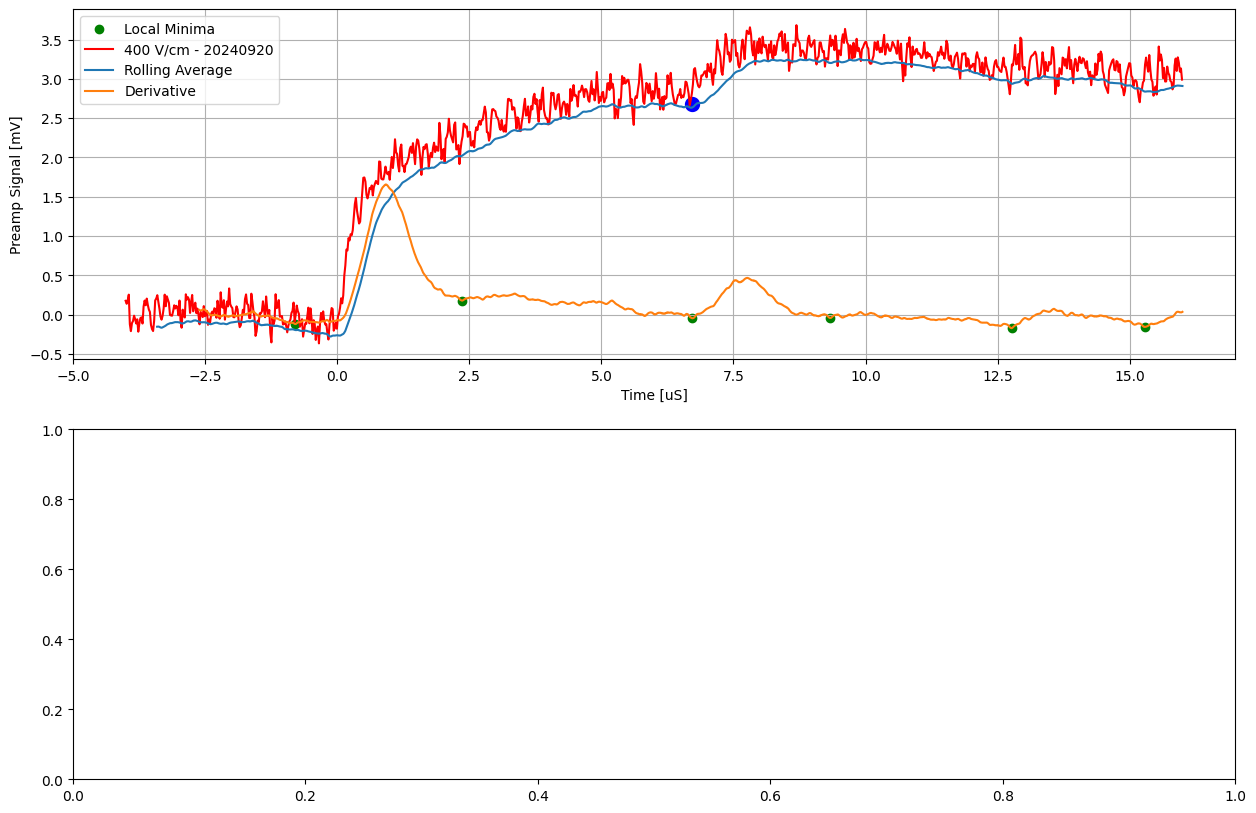

In [375]:

wafeform_path="C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/" # Path for data On left pc

dates =     [20240920,20240920,20240920,20240926,20240926,20240926,20240926,20240926]
runnumbers= [112     ,114     ,115     ,116     ,117,119,120,121]
labels=[400,500,500,400,400,500,600,700]

c=["red","blue","magenta","cyan","brown","grey","skyblue","teal"]


anode_time_delay=[]

fig, axs = plt.subplots(2, 1,figsize=(15,10))


for i,rn  in enumerate(runnumbers[1:2]):
    print(i)
    waveform_date ="%i"%(dates[i])
    runnumber="00%i"%(rn)
    stepcount=5
    waveform_dir=wafeform_path+waveform_date+"/"+waveform_date+"-"+runnumber
    waveform_wavenumber="10"
    waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
    waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
    DF=pd.read_csv(waveform_fullpath,skiprows=[1])



    anodenorm=np.average(DF["average(Anode)"][:100])
    cathnorm=np.average(DF["average(Cathode)"][:100])


    axs
    axs[i].errorbar(x=DF["Time"][::stepcount],y=DF["average(Anode)"][::stepcount] - anodenorm, color= c[i], label="%i V/cm - %s"%(labels[i],waveform_date))
    #axs[1].errorbar(x=DF["Time"][::stepcount],y=DF["average(Cathode)"][::stepcount] - cathnorm, color= c[i], label="%i V/cm"%(labels[i]))

    stepsize=150
    diffsize=200

    xdata=np.array(DF["Time"])
    ydata=DF["average(Anode)"]-np.average(DF["average(Anode)"][:20])
    yrolling=ydata.rolling(stepsize).mean()
    yprime=np.array(yrolling.diff(diffsize))
    ydata_nparray=np.array(ydata)
    axs[i].errorbar(xdata,yrolling,label="Rolling Average")
    axs[i].errorbar(xdata,yprime,label="Derivative")


    local_minima_indices = argrelextrema(np.array(yprime), np.less,order=250)

    print(local_minima_indices)
    # Get the x and y values of the local minima
    x_minima = xdata[local_minima_indices]
    y_minima = yprime[local_minima_indices]
    axs[i].scatter(x_minima, y_minima, color='green', label='Local Minima', zorder=1)
    
    
    ydata_minima = ydata_nparray[local_minima_indices[0][0]]
    #axs[i].scatter(x_minima[1], ydata_minima, color=c[i])
    
    time_delay_ind=0
    time_delay=xdata[np.array(local_minima_indices)[0][0]]
    if time_delay <5:
        time_delay_ind=1
        time_delay=xdata[np.array(local_minima_indices)[0][time_delay_ind]]
        if time_delay <5:
            time_delay_ind=2
            time_delay=xdata[np.array(local_minima_indices)[0][time_delay_ind]]
    
    anode_time_delay.append(xdata[np.array(local_minima_indices)[0][time_delay_ind]])
    ydata_minima = ydata_nparray[local_minima_indices[0][time_delay_ind]]
    axs[i].scatter(x_minima[time_delay_ind], ydata_minima, color=c[i+1],marker="o",lw=5)



    axs[i].grid()
    axs[i].legend()
print(anode_time_delay)
#axs[0].set_xlabel("Time [uS]")
axs[0].set_ylabel("Preamp Signal [mV]")
#axs[0].grid()
axs[0].legend()

axs[0].set_xlabel("Time [uS]")
#axs[1].set_ylabel("Preamp Signal [mV]")
#axs[1].grid()
#axs[1].legend()

    #plt.title("Signal on 20240926")
#plt.xlim(-1000,10000)


##  Anode delay time extraction for runs 112     ,114     ,115     ,116     ,117,119,120,121

(array([2728, 3304, 4493, 4992], dtype=int64),)
Run 00112  - time Delay  6.90399979
(array([ 802, 1593, 2683, 4194, 4823], dtype=int64),)
Run 00114  - time Delay  6.72399979
(array([ 986, 1664, 2473, 3375, 4913], dtype=int64),)
Run 00115  - time Delay  5.88399981
(array([ 991, 2685, 3792, 4188], dtype=int64),)
Run 00116  - time Delay  6.73199979
(array([ 965, 2748, 3309, 3789, 4320, 4881], dtype=int64),)
Run 00117  - time Delay  6.98399978
(array([1006, 3400, 4897], dtype=int64),)
Run 00119  - time Delay  9.59399971
(array([1003, 2645, 3203, 4312], dtype=int64),)
Run 00120  - time Delay  6.5719998
(array([ 713, 3091, 3688, 4999], dtype=int64),)
Run 00121  - time Delay  8.35599975
[6.90399979, 6.72399979, 5.88399981, 6.73199979, 6.98399978, 9.59399971, 6.5719998, 8.35599975]


Text(0.5, 0, 'Time [uS]')

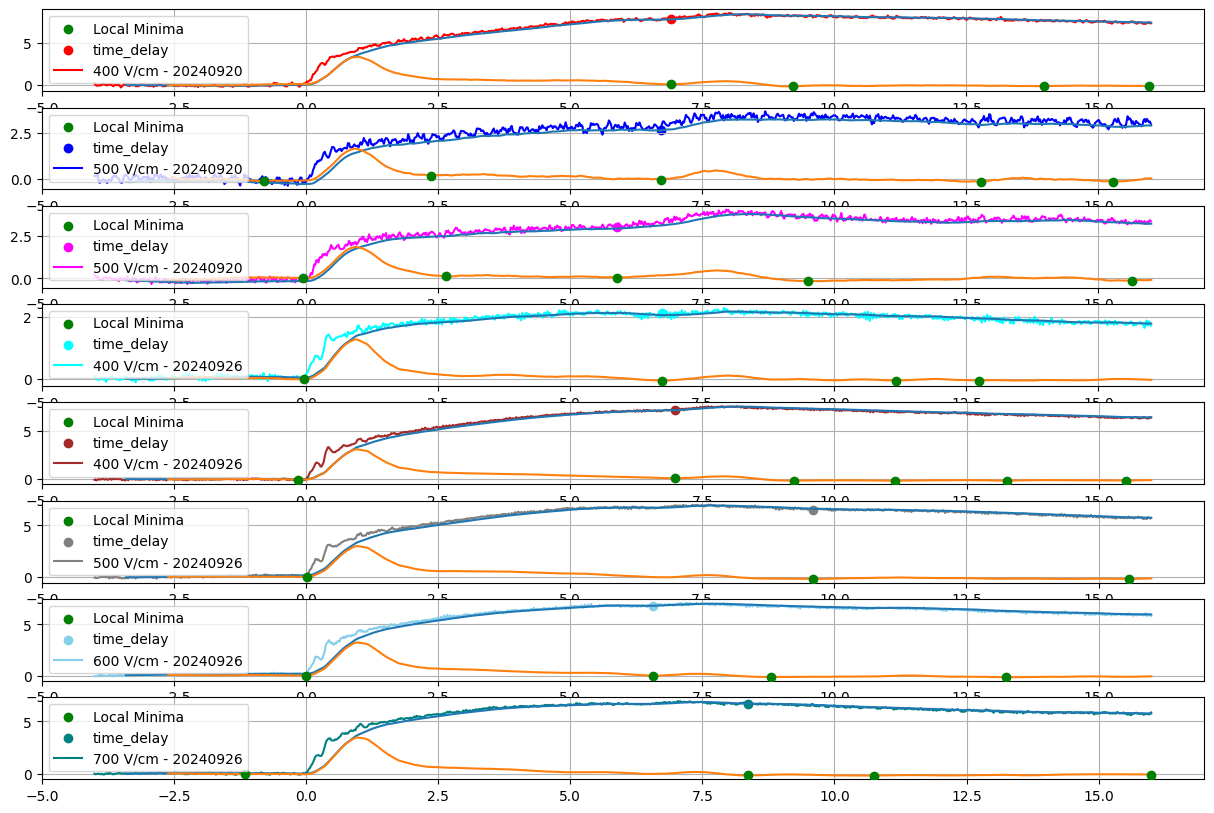

In [281]:

wafeform_path="C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/" # Path for data On left pc

dates =     [20240920,20240920,20240920,20240926,20240926,20240926,20240926,20240926]
runnumbers= [112     ,114     ,115     ,116     ,117,119,120,121]
labels=[400,500,500,400,400,500,600,700]

c=["red","blue","magenta","cyan","brown","grey","skyblue","teal"]


anode_time_delay=[]

fig, axs = plt.subplots(len(runnumbers), 1,figsize=(15,10))


for i,rn  in enumerate(runnumbers):
    
    waveform_date ="%i"%(dates[i])
    runnumber="00%i"%(rn)
    stepcount=5
    waveform_dir=wafeform_path+waveform_date+"/"+waveform_date+"-"+runnumber
    waveform_wavenumber="10"
    waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
    waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
    DF=pd.read_csv(waveform_fullpath,skiprows=[1])



    anodenorm=np.average(DF["average(Anode)"][:100])
    cathnorm=np.average(DF["average(Cathode)"][:100])


    axs
    axs[i].errorbar(x=DF["Time"][::stepcount],y=DF["average(Anode)"][::stepcount] - anodenorm, color= c[i], label="%i V/cm - %s"%(labels[i],waveform_date))
    #axs[1].errorbar(x=DF["Time"][::stepcount],y=DF["average(Cathode)"][::stepcount] - cathnorm, color= c[i], label="%i V/cm"%(labels[i]))

    stepsize=150
    diffsize=200

    xdata=np.array(DF["Time"])
    ydata=DF["average(Anode)"]-np.average(DF["average(Anode)"][:20])
    yrolling=ydata.rolling(stepsize).mean()
    yprime=np.array(yrolling.diff(diffsize))
    ydata_nparray=np.array(ydata)
    axs[i].errorbar(xdata,yrolling)
    axs[i].errorbar(xdata,yprime)


    #local_minima_indices = argrelextrema(np.array(yprime), np.greater,order=350)
    local_minima_indices = argrelextrema(np.array(yprime), np.less,order=350)

    print(local_minima_indices)
    # Get the x and y values of the local minima
    x_minima = xdata[local_minima_indices]
    y_minima = yprime[local_minima_indices]
    axs[i].scatter(x_minima, y_minima, color='green', label='Local Minima', zorder=5)
    
    
    ydata_minima = ydata_nparray[local_minima_indices[0][0]]
    #axs[i].scatter(x_minima[1], ydata_minima, color=c[i])
    
    time_delay_ind=0
    time_delay=xdata[np.array(local_minima_indices)[0][0]]
    if time_delay <5:
        time_delay_ind=1
        time_delay=xdata[np.array(local_minima_indices)[0][time_delay_ind]]
        if time_delay <5:
            time_delay_ind=2
            time_delay=xdata[np.array(local_minima_indices)[0][time_delay_ind]]
    

    print("Run %s  - time Delay "%(runnumber) ,xdata[np.array(local_minima_indices)[0][time_delay_ind]],   )

    anode_time_delay.append(xdata[np.array(local_minima_indices)[0][time_delay_ind]])
    ydata_minima = ydata_nparray[local_minima_indices[0][time_delay_ind]]
    axs[i].scatter(x_minima[time_delay_ind], ydata_minima, color=c[i], label="time_delay")



    axs[i].grid()
    axs[i].legend()
print(anode_time_delay)
#axs[0].set_xlabel("Time [uS]")
#axs[0].set_ylabel("Preamp Signal [mV]")
#axs[0].grid()
axs[0].legend()

axs[3].set_xlabel("Time [uS]")
#axs[1].set_ylabel("Preamp Signal [mV]")
#axs[1].grid()
#axs[1].legend()

    #plt.title("Signal on 20240926")
#plt.xlim(-1000,10000)


##  Cathode delay time extraction for runs 112     ,114     ,115     ,116     ,117,119,120,121

1.08399995
-19.186422299999997
1.17199995
-10.276239169999998
1.22799995
-11.034281299999998
0.97199995
-6.062645800000009
0.96799995
-15.674215500000003
1.00199995
-17.529075099999996
0.96399995
-19.765023
0.94399995
-27.445324299999996


Text(0.5, 0, 'Time [uS]')

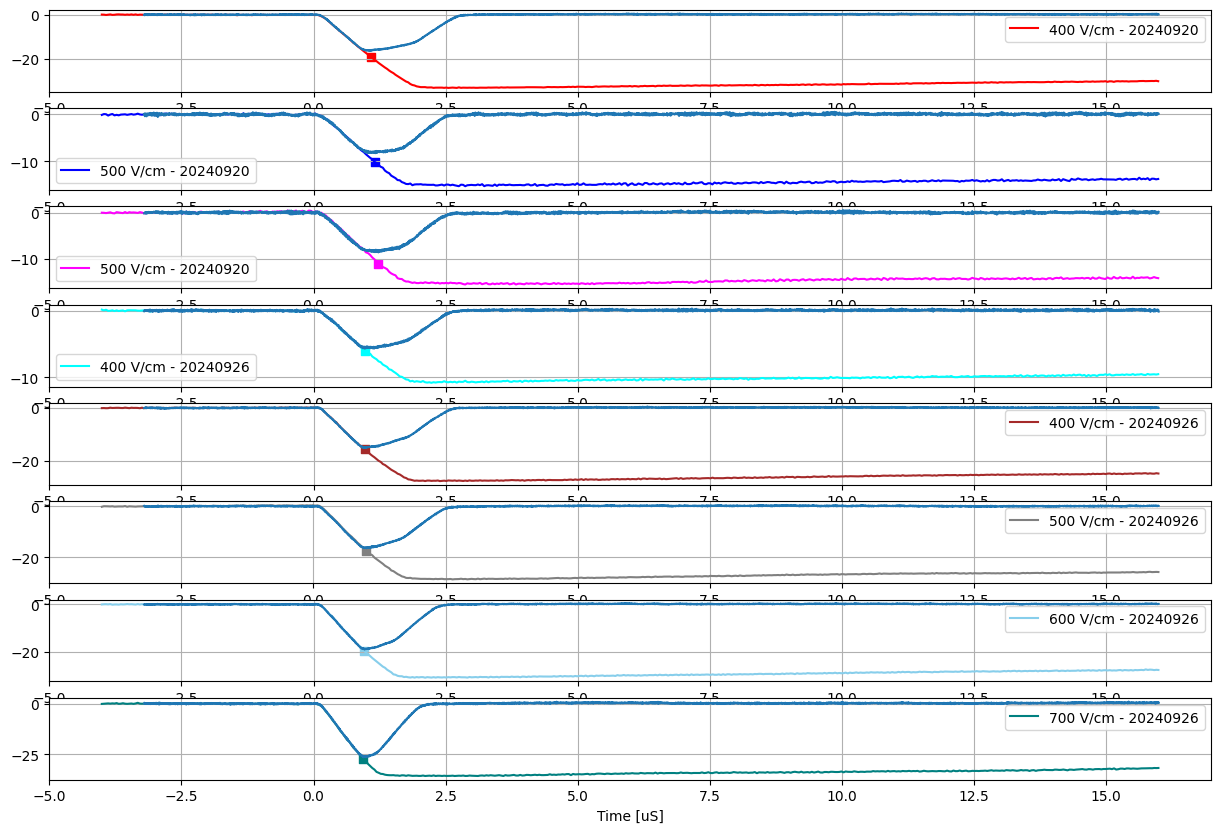

In [277]:
wafeform_path="C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/" # Path for data On left pc

# dates = [20240926,20240926,20240926,20240926]
# runnumbers= [117,119,120,121]

# voltages_raw= np.array([400,500,600,700])
voltages_raw=labels
#c=["red","blue","magenta","cyan"]





fig, axs = plt.subplots(len(runnumbers), 1,figsize=(15,10))

catho_delay=[]
for i,rn  in enumerate(runnumbers):
    
    waveform_date ="%i"%(dates[i])
    runnumber="00%i"%(rn)
    stepcount=10
    waveform_dir=wafeform_path+waveform_date+"/"+waveform_date+"-"+runnumber
    waveform_wavenumber="10"
    waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
    waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
    DF=pd.read_csv(waveform_fullpath,skiprows=[1])



    anodenorm=np.average(DF["average(Anode)"][:100])
    cathnorm=np.average(DF["average(Cathode)"][:100])


    axs
    #axs[i].errorbar(x=DF["Time"][::stepcount],y=DF["average(Anode)"][::stepcount] - anodenorm, color= c[i], label="%i V/cm"%(labels[i]))
    axs[i].errorbar(x=DF["Time"][::stepcount],y=DF["average(Cathode)"][::stepcount] - cathnorm, color= c[i], label="%i V/cm - %s"%(labels[i],waveform_date))
    
    axs[i].grid()

    axs[i].legend()

    Time=np.array(DF["Time"])
    Cath =DF["average(Cathode)"] - cathnorm
    diff = Cath.diff(200)

    axs[i].errorbar(Time,diff,label="Diff")


    cond= np.abs(diff)== np.max(np.abs(diff))
    #cond= np.abs(diff)>=1


    print(Time[np.where(cond)][-1])
    cd=Time[np.where(cond)][-1]
    cd_amp=np.array(Cath.iloc[np.where(cond)])[-1]
    catho_delay.append(cd)
    print(cd_amp)

    axs[i].scatter(cd,cd_amp,marker="s",color=c[i])
    #catho_delay.append(Time[np.where(Cath == Cath_min)][0])
    #axs[i].set_xlim(-1,3)

axs[i].set_xlabel("Time [uS]")
#print(catho_delay)


#axs[i].set_ylim(-37,-28)
#axs[i].set_xlim(-1,3)

2.7159999
-33.2136333


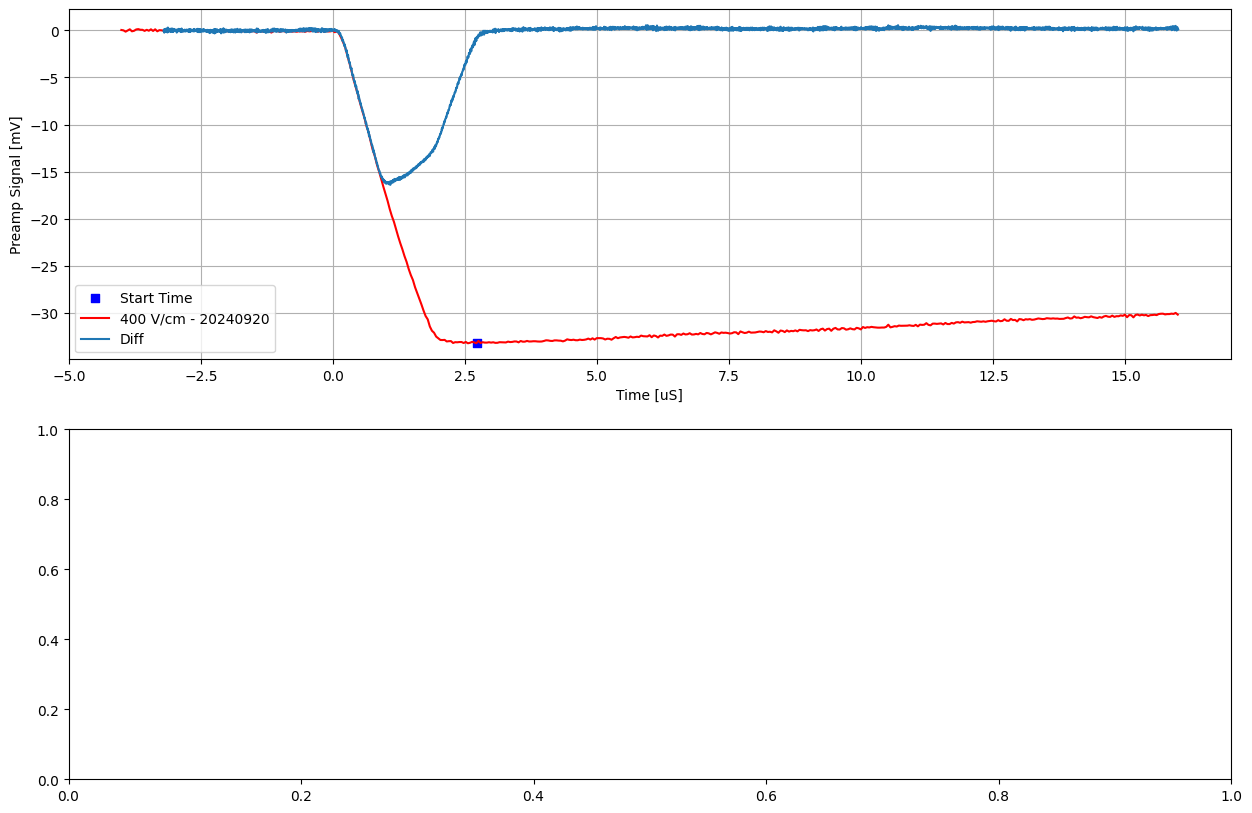

In [255]:
wafeform_path="C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/" # Path for data On left pc

# dates = [20240926,20240926,20240926,20240926]
# runnumbers= [117,119,120,121]

# voltages_raw= np.array([400,500,600,700])
voltages_raw=labels
#c=["red","blue","magenta","cyan"]





fig, axs = plt.subplots(2, 1,figsize=(15,10))

catho_delay=[]
for i,rn  in enumerate(runnumbers[:1]):
    
    waveform_date ="%i"%(dates[i])
    runnumber="00%i"%(rn)
    stepcount=10
    waveform_dir=wafeform_path+waveform_date+"/"+waveform_date+"-"+runnumber
    waveform_wavenumber="10"
    waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
    waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
    DF=pd.read_csv(waveform_fullpath,skiprows=[1])



    anodenorm=np.average(DF["average(Anode)"][:100])
    cathnorm=np.average(DF["average(Cathode)"][:100])


    axs
    #axs[i].errorbar(x=DF["Time"][::stepcount],y=DF["average(Anode)"][::stepcount] - anodenorm, color= c[i], label="%i V/cm"%(labels[i]))
    axs[i].errorbar(x=DF["Time"][::stepcount],y=DF["average(Cathode)"][::stepcount] - cathnorm, color= c[i], label="%i V/cm - %s"%(labels[i],waveform_date))
    
    axs[i].grid()

    axs[i].legend()

    Time=np.array(DF["Time"])
    Cath =DF["average(Cathode)"] - cathnorm
    diff = Cath.diff(200)

    axs[i].errorbar(Time,diff,label="Diff")


    #cond= np.abs(diff) == np.max(np.abs(diff))
    cond= np.abs(diff) >1


    
    cd=Time[np.where(cond)][-1]
    cd_amp=np.array(Cath.iloc[np.where(cond)])[-1]
    print(cd)
    catho_delay.append(cd)
    print(cd_amp)

    axs[i].scatter(cd,cd_amp,marker="s",color=c[i+1],label="Start Time")
    #catho_delay.append(Time[np.where(Cath == Cath_min)][0])
    #axs[i].set_xlim(-1,3)

axs[i].set_xlabel("Time [uS]")
axs[i].set_ylabel("Preamp Signal [mV]")
axs[i].legend()
#print(catho_delay)


#axs[i].set_ylim(-37,-28)
#axs[i].set_xlim(-1,3)

## Error analysis

In [87]:


drift_length_stddev = 0.12
drift_length=9.14


dl_per_error=drift_length_stddev/drift_length



voltage_uncertainty = 5*2
volt_per_error=np.array(voltage_uncertainty)/voltages_raw


drift_field_pre_error = np.sqrt( volt_per_error**2 + dl_per_error**2 )
drift_field_error=drift_field_pre_error*voltages_raw

In [88]:
np.round((np.array(anode_time_delay)-catho_delay),3)

array([6.044, 5.648, 5.516, 5.344])

In [89]:
drift_time_LXe_Sept=np.array([5.224, 5.348, 5.364, 5.564, 5.336, 5.116, 5.044, 5.3])
#drift_time_main=np.array([5.068, 5.136, 5.164, 5.524, 5.228,5.08, 5.008, 5.212])

drift_time_2nd =np.array([4.79999986, 4.71199986, 4.65599986, 4.91199986, 4.91599986,
       4.88199986, 4.91999986, 4.93999986])

delta_v_1 = abs(drift_length/drift_time_LXe_Sept - drift_length/drift_time_2nd)

print(delta_v_1)





[0.15454957 0.2306783  0.2591062  0.21804615 0.14634165 0.08563159
 0.0456697  0.12567418]


## Phys. Rev. 166, 871 - data

In [47]:
ChT_Vs=np.array([41.368,128.825, 194.984, 395.063, 579.874, 794.328])

ChT_dv= np.array([0.763 ,1.416, 1.59, 1.813, 1.899, 2.052])

## J. Yoo and W.F. Jaskierny 2015 JINST 10 P08011    --Data

In [46]:
AAA = [200, 0.148 , 0.003, 0.181 , 0.003, 1.22,
250, 0.157 , 0.004, 0.200 , 0.004, 1.27,
300, 0.162 , 0.003, 0.227 , 0.004, 1.40,
350, 0.166 , 0.003, 0.245 , 0.005, 1.48,
400, 0.167 , 0.003, 0.255 , 0.004, 1.53,
450, 0.174 , 0.004, 0.266 , 0.004, 1.53,
500, 0.177 , 0.003, 0.274 , 0.004, 1.55,
550, 0.180 , 0.004, 0.288 , 0.005, 1.60,
600, 0.184 , 0.003, 0.302 , 0.006, 1.64,
650, 0.186 , 0.003, 0.325 , 0.006, 1.74,
700, 0.189 , 0.006, 0.343 , 0.005, 1.82,
750, 0.191 , 0.003, 0.357 , 0.005, 1.87,
800, 0.193 , 0.003, 0.382 , 0.007, 1.98,
850, 0.194 , 0.003, 0.390 , 0.007, 2.01,
900, 0.193 , 0.003, 0.397 , 0.006, 2.05]


JINST_2015_dict={}

vs=[]
lds=[]
lds_e=[]
for i in np.arange(0,15,1):
    vs.append(AAA[i*6])
    lds.append(AAA[i*6+1]*10)
    lds_e.append(AAA[i*6+2])
JINST_2015_dict["Voltage"]=vs
JINST_2015_dict["DriftSpeed"]=lds
JINST_2015_dict["Error"]=lds_e




## Drift veloctity plot for njoya, Sept 20th, and 26th

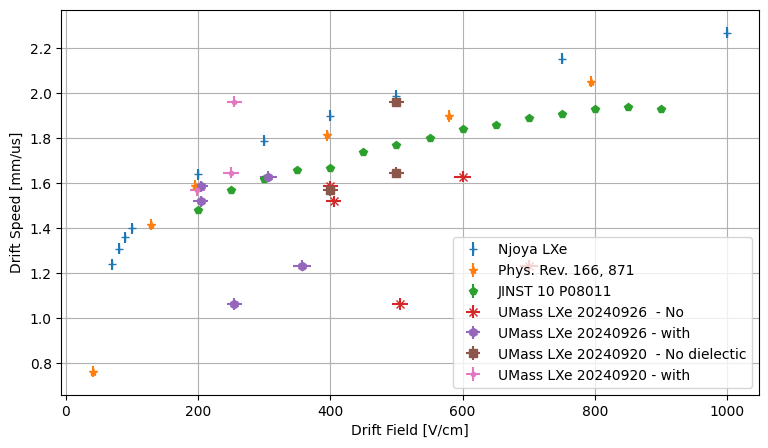

In [286]:
fig,ax= plt.subplots(1, 1, figsize=(9,5))


#print(bx)
colors=["r","blue","darkgrey","green","cyan","purple"]
marker=["o","x","p","s","h","*"]
markersize=7

sec=0

##Njoya liquid data
#njoya_y1=np.array([20,20/1.1,20/1.3,20/1.4,20/1.5,20/1.7])-1
#njoya_y2=np.array([20,20/1.1,20/1.3,20/1.4,20/1.5,20/1.7])+1
njyl=np.array([1.24,1.31,1.36,1.4,1.64,1.79,1.9,1.99,2.154,2.2685])
njxl=np.array([70,80,90,100,200,300,400,500,750,1000])
#njoya_x=[200*2,200*2,300*2,400*2,500*2,1000*2]

njoya_x=njxl
njoya_y=njyl

ax.errorbar(x=njoya_x,y=njoya_y,yerr=0.025,fmt=" ",marker="+",label="Njoya LXe")
ax.errorbar(x=ChT_Vs,y=ChT_dv,yerr=0.025,fmt=" ", marker="*",label="Phys. Rev. 166, 871 ")

ax.errorbar(x= JINST_2015_dict["Voltage"],y=JINST_2015_dict["DriftSpeed"],fmt=" ",marker="p",
            yerr=JINST_2015_dict["Error"],label="JINST 10 P08011 ")




voltages_raw=np.array(labels)


offset=[-5,-5,0,0,5,5,0,0]

ax.errorbar(x=voltages_raw[3:]+offset[3:],y=9.14/(np.array(anode_time_delay)-catho_delay)[3:]
            ,xerr=drift_field_error[3:]
            ,yerr=0.025,fmt=" ",marker="x",label="UMass LXe 20240926  - No ")
ax.errorbar(x=voltages_raw[3:]/1.96,y=9.14/(np.array(anode_time_delay)-catho_delay)[3:]
            ,xerr=drift_field_error[3:]
            ,yerr=0.025,fmt=" ",marker="h",label="UMass LXe 20240926 - with")

ax.errorbar(x=voltages_raw[:3],y=9.14/(np.array(anode_time_delay)-catho_delay)[:3]
            ,xerr=drift_field_error[:3]
            ,yerr=0.025,fmt=" ",marker="s",label="UMass LXe 20240920  - No dielectic")
ax.errorbar(x=voltages_raw[:3]/1.96 +offset[:3],y=9.14/(np.array(anode_time_delay)-catho_delay)[:3]
            ,xerr=drift_field_error[:3]
            ,yerr=0.025,fmt=" ",marker=".",label="UMass LXe 20240920 - with")


ax.set_ylabel("Drift Speed [mm/us]")
ax.set_xlabel("Drift Field [V/cm]")


ax.grid()
ax.legend()


In [102]:
#drift_time_main=np.array([5.068, 5.136, 5.164, 5.524, 5.228,5.08, 5.008, 5.212])

In [90]:
voltages_raw

array([400, 500, 500, 400, 400, 500, 600, 700])

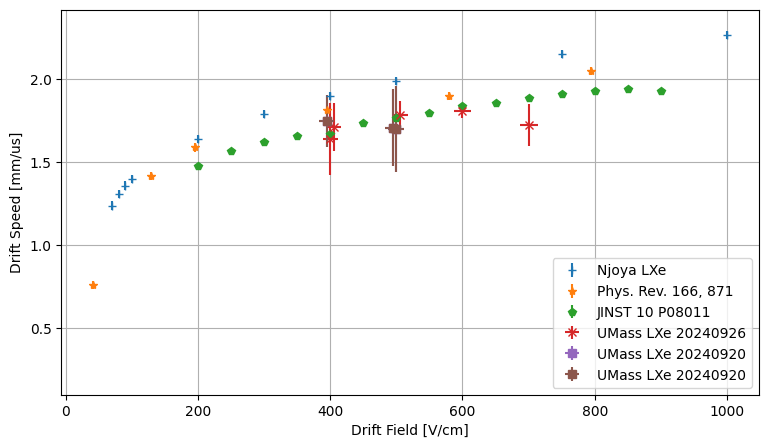

In [140]:
fig,ax= plt.subplots(1, 1, figsize=(9,5))


#print(bx)
colors=["r","blue","darkgrey","green","cyan","purple"]
marker=["o","x","p","s","h","*"]
markersize=7

sec=0

##Njoya liquid data
#njoya_y1=np.array([20,20/1.1,20/1.3,20/1.4,20/1.5,20/1.7])-1
#njoya_y2=np.array([20,20/1.1,20/1.3,20/1.4,20/1.5,20/1.7])+1
njyl=np.array([1.24,1.31,1.36,1.4,1.64,1.79,1.9,1.99,2.154,2.2685])
njxl=np.array([70,80,90,100,200,300,400,500,750,1000])
#njoya_x=[200*2,200*2,300*2,400*2,500*2,1000*2]

njoya_x=njxl
njoya_y=njyl


ax.errorbar(x=njoya_x,y=njoya_y,yerr=0.025,fmt=" ",marker="+",label="Njoya LXe")

ax.errorbar(x=ChT_Vs,y=ChT_dv,yerr=0.025,fmt=" ", marker="*",label="Phys. Rev. 166, 871 ")

ax.errorbar(x= JINST_2015_dict["Voltage"],y=JINST_2015_dict["DriftSpeed"],fmt=" ",marker="p",
            yerr=JINST_2015_dict["Error"],label="JINST 10 P08011 ")



voltages_raw=np.array(labels)

offset=[-5,-5,0,0,5,5,0,0]


ax.errorbar(x=voltages_raw[3:]+offset[3:],y=9.14/drift_time_LXe_Sept[3:]
            ,xerr=drift_field_error[3:]
           ,yerr=delta_v_1[3:],fmt=" ",marker="x",label="UMass LXe 20240926")
ax.errorbar(x=voltages_raw[:3] +offset[:3],y=9.14/drift_time_LXe_Sept[:3]
           ,xerr=drift_field_error[:3]
           ,yerr=delta_v_1[:3],fmt=" ",marker="s",label="UMass LXe 20240920")
# ax.errorbar(x=voltages_raw[3:]/1.96 +offset[3:],y=9.14/drift_time_main[3:]
#             ,xerr=drift_field_error[3:]
#             ,yerr=delta_v_1[3:],fmt=" ",marker="x",label="UMass LXe 20240926 ")

ax.errorbar(x=voltages_raw[:3] +offset[:3],y=9.14/drift_time_LXe_Sept[:3]
           ,xerr=drift_field_error[:3]
           ,yerr=delta_v_1[:3],fmt=" ",marker="s",label="UMass LXe 20240920")
# ax.errorbar(x=voltages_raw[:3]/1.96 +offset[:3],y=9.14/drift_time_main[:3]
#             ,xerr=drift_field_error[:3]
#             ,yerr=delta_v_1[:3],fmt=" ",marker=".",label="UMass LXe 20240920")





ax.set_ylabel("Drift Speed [mm/us]")
ax.set_xlabel("Drift Field [V/cm]")


ax.set_ylim(0.1,2.42)
ax.grid()
ax.legend()

# Playing around with background modeling

In [150]:
# Gaussian function definition
def gaussian(x, a, mu, sigma):
    return a * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))
def logarithmic_model(x, a, b):
    return a * np.log(b * x)

def dg(x,a,mu_a,sigma_a,m,b):
    return a * np.exp(-(x - mu_a) ** 2 / (2 * sigma_a ** 2)) +   (m + x*b)


# Define the skewed Gaussian function
def skewed_gaussian(x, alpha, mu, sigma, amplitude):
    # Standard normal PDF
    pdf = amplitude * (2 / sigma) * norm.pdf((x - mu) / sigma)
    # Skew factor
    cdf = norm.cdf(alpha * (x - mu) / sigma)
    return pdf * cdf




def errfunc(x, a, b, z, f):
    return a * scipy.special.erf((x - z)*f) + b

In [29]:
DF[:1]

,Time,Channel Trigger,Channel Cathode,Channel Anode,Channel UV,average(Cathode),average(Anode)
0,-4.008,0.0,55.56409,23.68971,0.0,51.41853,21.55292


In [6]:
from scipy.signal import argrelextrema
from scipy.stats import norm

4.336202200000001
[1264]
(array([ 420, 1264, 2816, 4812], dtype=int64),)
1.04799995
Err func fit par
[3.15164567 3.14885332 0.89079997 0.86589952] 
 [[ 4.46207765e-05 -2.73048256e-05 -2.49176512e-05 -3.62776229e-05]
 [-2.73048256e-05  4.24026245e-05  3.10044075e-05  2.49198199e-05]
 [-2.49176512e-05  3.10044075e-05  1.24837064e-04  8.54133514e-05]
 [-3.62776229e-05  2.49198199e-05  8.54133514e-05  1.71548815e-04]]
[7.84998283e-78 1.85256703e-77 3.30402006e-77 ... 5.62294698e+00
 5.62294698e+00 5.62294698e+00]
[0 0 0 ... 0 0 0]


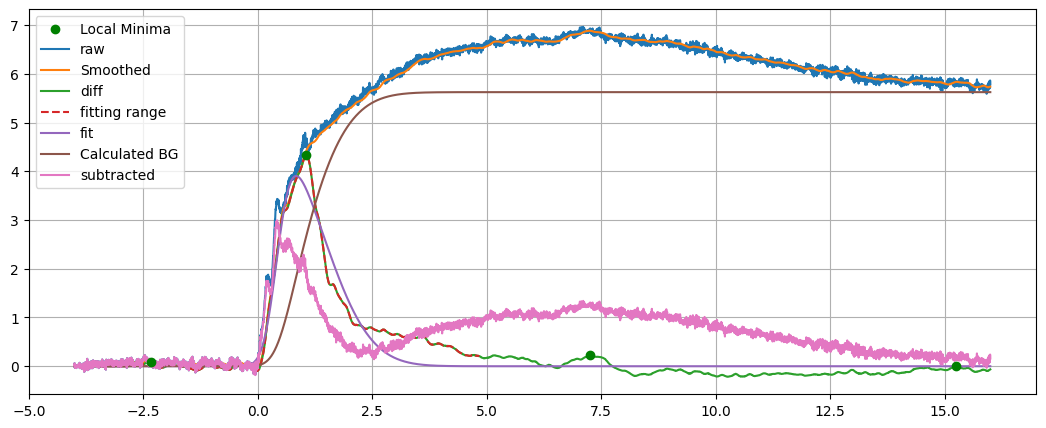

In [292]:
stepsize=50
diffsize=250

xdata=np.array(DF["Time"])
ydata=DF["average(Anode)"]-np.average(DF["average(Anode)"][:20])
yrolling=ydata.rolling(stepsize).mean()
yprime=np.array(yrolling.diff(diffsize))
yprime = np.nan_to_num(yprime,nan=0)

Fpeak_amp=np.max(yprime)

cond= yprime ==Fpeak_amp

print(Fpeak_amp)


#print(yprime.where("=%d"%(Fpeak_amp)))
Fpeak_loc=np.where( np.abs(yprime - Fpeak_amp) <=0.0001)[0]
print(Fpeak_loc)



x_fit_data=xdata[:int(Fpeak_loc[0]*1.750)]
y_fit_data=yprime[:int(Fpeak_loc[0]*1.750)]


fig = plt.figure(figsize=(13,5))
plt.errorbar(xdata,ydata, label="raw")
plt.errorbar(xdata,yrolling,label= "Smoothed")
plt.errorbar(xdata,yprime,label="diff")
plt.errorbar(x_fit_data,y_fit_data, fmt="--", label="fitting range")




local_minima_indices = argrelextrema(np.array(yprime), np.greater,order=350)
x_minima = xdata[local_minima_indices]
y_minima = yprime[local_minima_indices]
plt.scatter(x_minima, y_minima, color='green', label='Local Minima', zorder=5)

print(local_minima_indices)
second_peak_ind=local_minima_indices[0][1]
second_peak_time=xdata[second_peak_ind]
print(second_peak_time)



errguas_FR=np.concatenate([np.where(xdata <=-0.1)[0] , np.where( xdata > second_peak_time )[0]])


#ydata_err = ydata[errguas_FR]
errguass_guess=[np.max(ydata),np.min(ydata),second_peak_time,-0.5]
errguass_p_range=[ [-10,-10,second_peak_time*0.85,-2],[10,10,second_peak_time*1.25,2]]

params_err, cov_err = curve_fit(errfunc, xdata[errguas_FR], ydata[errguas_FR], p0=errguass_guess,bounds=errguass_p_range)
print("Err func fit par")
print(params_err,"\n",cov_err)
#plt.errorbar(xdata[errguas_FR], ydata[errguas_FR],fmt=" .", label="err fitrange")

yfit_err=errfunc(xdata, params_err[0],params_err[1],params_err[2],params_err[3])

#plt.errorbar(xdata,yfit_err,label="Errfunc")

# plt.errorbar(xdata,subtracted)

# # Fit the data using curve_fit
# initial_guess = [Fpeak_amp, xdata[Fpeak_loc][0], 2]  # Initial guess for a, mu, sigma
# print(initial_guess)
# params, covariance = curve_fit(gaussian, x_fit_data, y_fit_data, p0=initial_guess)
# # Extract the fitting parameters
# a_fit, mu_fit, sigma_fit = params
# # Generate the fitted Gaussian curve
# y_fit = gaussian(xdata, a_fit, mu_fit, sigma_fit)

# p0=[Fpeak_amp, xdata[Fpeak_loc][0], 2,0,-1]

# params, covariance = curve_fit(dg, x_fit_data, y_fit_data)
# # Extract the fitting parameters
# a, mu_a, sigma_a ,b,m = params
# # Generate the fitted Gaussian curve
# y_fit = dg(xdata, a, mu_a, sigma_a ,b,m )

# print(params)
# Initial guesses for the fitting parameters
initial_guess = [5, 0, 2, 8]  # Initial guess for alpha, mu, sigma, amplitude

# Fit the data
popt, pcov = curve_fit(skewed_gaussian, x_fit_data, y_fit_data, p0=initial_guess)

# Extract the optimal parameters
alpha_opt, mu_opt, sigma_opt, amplitude_opt = popt

# Generate fitted y values with the optimized parameters
y_fit = skewed_gaussian(xdata, alpha_opt, mu_opt, sigma_opt, amplitude_opt)



plt.errorbar(xdata,y_fit,label="fit")

Fpeak_int=np.cumsum(y_fit* (xdata[1]-xdata[0]))

Fpeak_valid=np.where(np.diff(Fpeak_int,50) > .005,1,0)
print(Fpeak_int)
print(Fpeak_valid)

subtracted = ydata-Fpeak_int


dsub=ydata-subtracted
plt.errorbar(xdata,Fpeak_int,label="Calculated BG")
plt.errorbar(xdata,subtracted,label="subtracted")



#plt.ylim(-0.1,8)
#plt.xlim(-2.15,15)
plt.legend()

plt.grid()

array([   0,    1,    2, ..., 5000, 5001, 5002], dtype=int64)

In [339]:
from lmfit.models import SkewedGaussianModel

In [45]:
xdata[2250:2500]

2250    4.992
2251    4.996
2252    5.000
2253    5.004
2254    5.008
        ...  
2495    5.972
2496    5.976
2497    5.980
2498    5.984
2499    5.988
Name: Time, Length: 250, dtype: float64

In [41]:
import subprocess
rn="119"

flist = glob.glob("A:/DATA/waveforms/20240926-00%s/*"%(rn))
print(flist)
for f in flist:

    f=f.replace("\\","/")
    nename = f.replace("000","00")
    
    print(f,"\n", nename)
    subprocess.Popen(["mv" ,"-v", "%s %s"%(f, nename)])




['A:/DATA/waveforms/20240926-00119\\20240926-000119_01.csv', 'A:/DATA/waveforms/20240926-00119\\20240926-000119_02.csv', 'A:/DATA/waveforms/20240926-00119\\20240926-000119_03.csv', 'A:/DATA/waveforms/20240926-00119\\20240926-000119_04.csv', 'A:/DATA/waveforms/20240926-00119\\20240926-000119_05.csv', 'A:/DATA/waveforms/20240926-00119\\20240926-000119_06.csv', 'A:/DATA/waveforms/20240926-00119\\20240926-000119_07.csv', 'A:/DATA/waveforms/20240926-00119\\20240926-000119_08.csv', 'A:/DATA/waveforms/20240926-00119\\20240926-000119_09.csv', 'A:/DATA/waveforms/20240926-00119\\20240926-000119_10.csv', 'A:/DATA/waveforms/20240926-00119\\20240926-000119_11.csv']
A:/DATA/waveforms/20240926-00119/20240926-000119_01.csv 
 A:/DATA/waveforms/20240926-00119/20240926-00119_01.csv


FileNotFoundError: [WinError 2] The system cannot find the file specified

In [31]:
r=21.5
d=803
rho = 2* np.pi *r/d


Rmin = (1+rho)/(1-rho)
Rmin,rho

(1.4045101211444562, 0.16822974359198145)

In [60]:
r=37/2
d=217
rho = 2* np.pi *r/d


Rmin = (1+rho)/(1-rho)
Rmin

3.3072189703128196

In [41]:
( + (d/(4 *np.pi *1.8 ))* (rho**2 - 4* np.log(rho) ) )

254.1118254637591

In [47]:
(220/1.8) / (366/9.14)

3.0522161505768066

In [61]:
Eq_2_Num=(1 + (d/(4 *np.pi *1.8 ))* (rho**2 - 4* np.log(rho) ) )*(1+rho)
Eq_2_den=(1 + (d/(4 *np.pi *9.14))* (rho**2 - 4* np.log(rho) ) )*(1+rho)


Eq_2_Num/Eq_2_den


4.426346291708176

# 20241007 data

## Gas data runs 137,138,139

500.0
(array([  796,  2160,  2722,  4742,  6241,  6996,  9055,  9985, 11231,
       11808, 12274], dtype=int64),)
Run 00137  - time Delay  8.9599998
2.17599999
-60.45843909999999
400.43763676148797
(array([ 1200,  1654,  2726,  4852,  6844,  7551,  8175,  8889, 10488,
       11924], dtype=int64),)
Run 00138  - time Delay  9.40239979
2.34639999
-52.19277890000001
299.781181619256
(array([ 1337,  2722,  4968,  6101,  7719,  8899, 10415, 10851, 12275],
      dtype=int64),)
Run 00139  - time Delay  9.86599978
2.43799999
-43.09558009999999
cath
[2.17599999, 2.34639999, 2.43799999]
anode
[8.9599998, 9.40239979, 9.86599978]
Drift time
[6.78399981 7.0559998  7.42799979]
[500.0, 400.43763676148797, 299.781181619256]


Text(0.5, 0, 'Time [uS]')

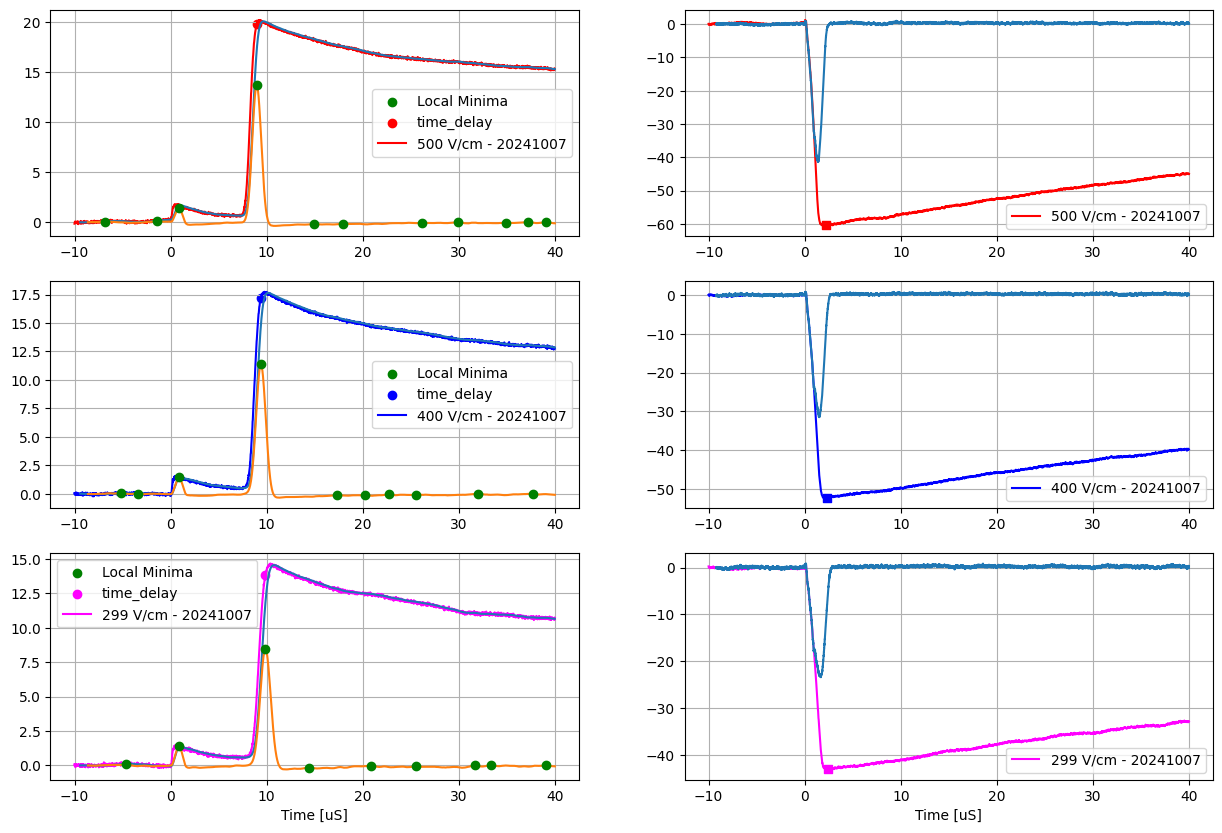

In [223]:

wafeform_path="C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/" # Path for data On left pc

dates =     [20241007,20241007,20241007]
runnumbers= [137     ,138     ,139]
labels=[400,500,500,400,400,500,600,700]

c=["red","blue","magenta","cyan","brown","grey","skyblue","teal"]

chann_names=["Avg Cathode","Avg Anode"]

anode_time_delay=[]
catho_delay=[]
drift_field_list=[]
fig, axs = plt.subplots(len(runnumbers), 2,figsize=(15,10))


for i,rn  in enumerate(runnumbers):
    
    waveform_date ="%i"%(dates[i])
    runnumber="00%i"%(rn)
    stepcount=5
    waveform_dir=wafeform_path+waveform_date+"/"+waveform_date+"-"+runnumber
    waveform_wavenumber="10"
    waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
    waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
    DF=pd.read_csv(waveform_fullpath,skiprows=[1])
    RI = GetRunInfo(rn)

    drift_field = RI["Cathode Grid V."].iloc[0]/(9.14/10)
    print(drift_field)

    anodenorm=np.average(DF[chann_names[1]][:100])
    cathnorm=np.average(DF[chann_names[0]][:100])


    axs
    axs[i][0].errorbar(x=DF["Time"][::stepcount],y=DF[chann_names[1]][::stepcount] - anodenorm, color= c[i], label="%i V/cm - %s"%(drift_field,waveform_date))
    #axs[1].errorbar(x=DF["Time"][::stepcount],y=DF["average(Cathode)"][::stepcount] - cathnorm, color= c[i], label="%i V/cm"%(labels[i]))

    stepsize=150
    diffsize=200

    xdata=np.array(DF["Time"])
    ydata=DF[chann_names[1]]-np.average(DF[chann_names[1]][:20])
    yrolling=ydata.rolling(stepsize).mean()
    yprime=np.array(yrolling.diff(diffsize))
    ydata_nparray=np.array(ydata)
    axs[i][0].errorbar(xdata,yrolling)
    axs[i][0].errorbar(xdata,yprime)


    local_minima_indices = argrelextrema(np.array(yprime), np.greater,order=350)
    #local_minima_indices = argrelextrema(np.array(yprime), np.less,order=350)

    print(local_minima_indices)
    # Get the x and y values of the local minima
    x_minima = xdata[local_minima_indices]
    y_minima = yprime[local_minima_indices]
    axs[i][0].scatter(x_minima, y_minima, color='green', label='Local Minima', zorder=5)
    
    
    ydata_minima = ydata_nparray[local_minima_indices[0][0]]
    #axs[i].scatter(x_minima[1], ydata_minima, color=c[i])
    
    time_delay_ind=0
    time_delay=xdata[np.array(local_minima_indices)[0][0]]
    while time_delay <3 :
        time_delay_ind=1 +time_delay_ind
        time_delay=xdata[np.array(local_minima_indices)[0][time_delay_ind]]
        if time_delay_ind > len(np.array(local_minima_indices)[0]) -1:
            print("Breaking out of while loop")
            break
        

    print("Run %s  - time Delay "%(runnumber) ,xdata[np.array(local_minima_indices)[0][time_delay_ind]],   )

    anode_time_delay.append(xdata[np.array(local_minima_indices)[0][time_delay_ind]])
    ydata_minima = ydata_nparray[local_minima_indices[0][time_delay_ind]]
    axs[i][0].scatter(x_minima[time_delay_ind], ydata_minima, color=c[i], label="time_delay")



    axs[i][0].grid()
    axs[i][0].legend()

##cathods

    axs[i][1].errorbar(x=DF["Time"][::stepcount],y=DF[chann_names[0]][::stepcount] - cathnorm, color= c[i], label="%i V/cm - %s"%(drift_field,waveform_date))
    axs[i][1].grid()
    axs[i][1].legend()

    Time=np.array(DF["Time"])
    Cath =DF[chann_names[0]] - cathnorm
    diff = Cath.diff(200)

    axs[i][1].errorbar(Time,diff,label="Diff")


    #cond= np.abs(diff)== np.max(np.abs(diff))
    cond= np.abs(diff)>=5


    print(Time[np.where(cond)][-1])
    cd=Time[np.where(cond)][-1]
    cd_amp=np.array(Cath.iloc[np.where(cond)])[-1]
    catho_delay.append(cd)
    print(cd_amp)

    axs[i][1].scatter(cd,cd_amp,marker="s",color=c[i])
    #catho_delay.append(Time[np.where(Cath == Cath_min)][0])
    #axs[i].set_xlim(-1,3)
    drift_field_list.append(drift_field)
axs[i][1].set_xlabel("Time [uS]")




print("cath")
print(catho_delay)
print("anode")
print(anode_time_delay)

Drift_time=np.array(anode_time_delay)-np.array(catho_delay)

print("Drift time")
print(Drift_time)
print(drift_field_list)


    

#axs[0].set_xlabel("Time [uS]")
#axs[0].set_ylabel("Preamp Signal [mV]")
#axs[0].grid()
axs[0][0].legend()


axs[i][0].set_xlabel("Time [uS]")
#axs[1].set_ylabel("Preamp Signal [mV]")
#axs[1].grid()
#axs[1].legend()

    #plt.title("Signal on 20240926")
#plt.xlim(-1000,10000)


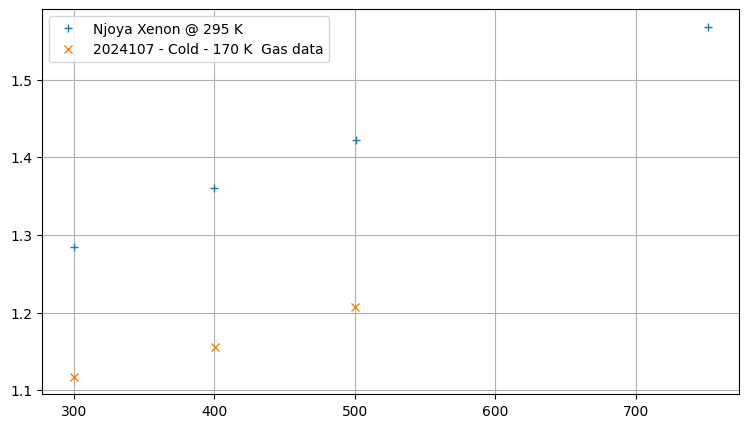

In [103]:
Runlist_DF["Extraction Distance"] = 1.83
Runlist_DF["Collection Distance"] = 1.83
Runlist_DF["Drift Distance"] = 9.185
Runlist_DF["Drift Distance Error"] = 0.15


# LXe data runs 143-147

Run 00143   Field 599.562363  time Delay  8.05799983
2.046
-60.208840499999994
0
Run 00144   Field 700.218818  time Delay  7.73149984
2.0835
-185.061368
1
Run 00145   Field 799.781182  time Delay  7.55679984
2.0408
-202.3755627
2
Run 00146   Field 900.000000  time Delay  7.36079985
2.0168
-210.6503851
3
cath
[2.046, 2.0835, 2.0408, 2.0168]
anode
[8.05799983, 7.73149984, 7.55679984, 7.36079985]
Drift time
[6.01199983 5.64799984 5.51599984 5.34399985]
[599.562363238512, 700.218818380744, 799.781181619256, 900.0]


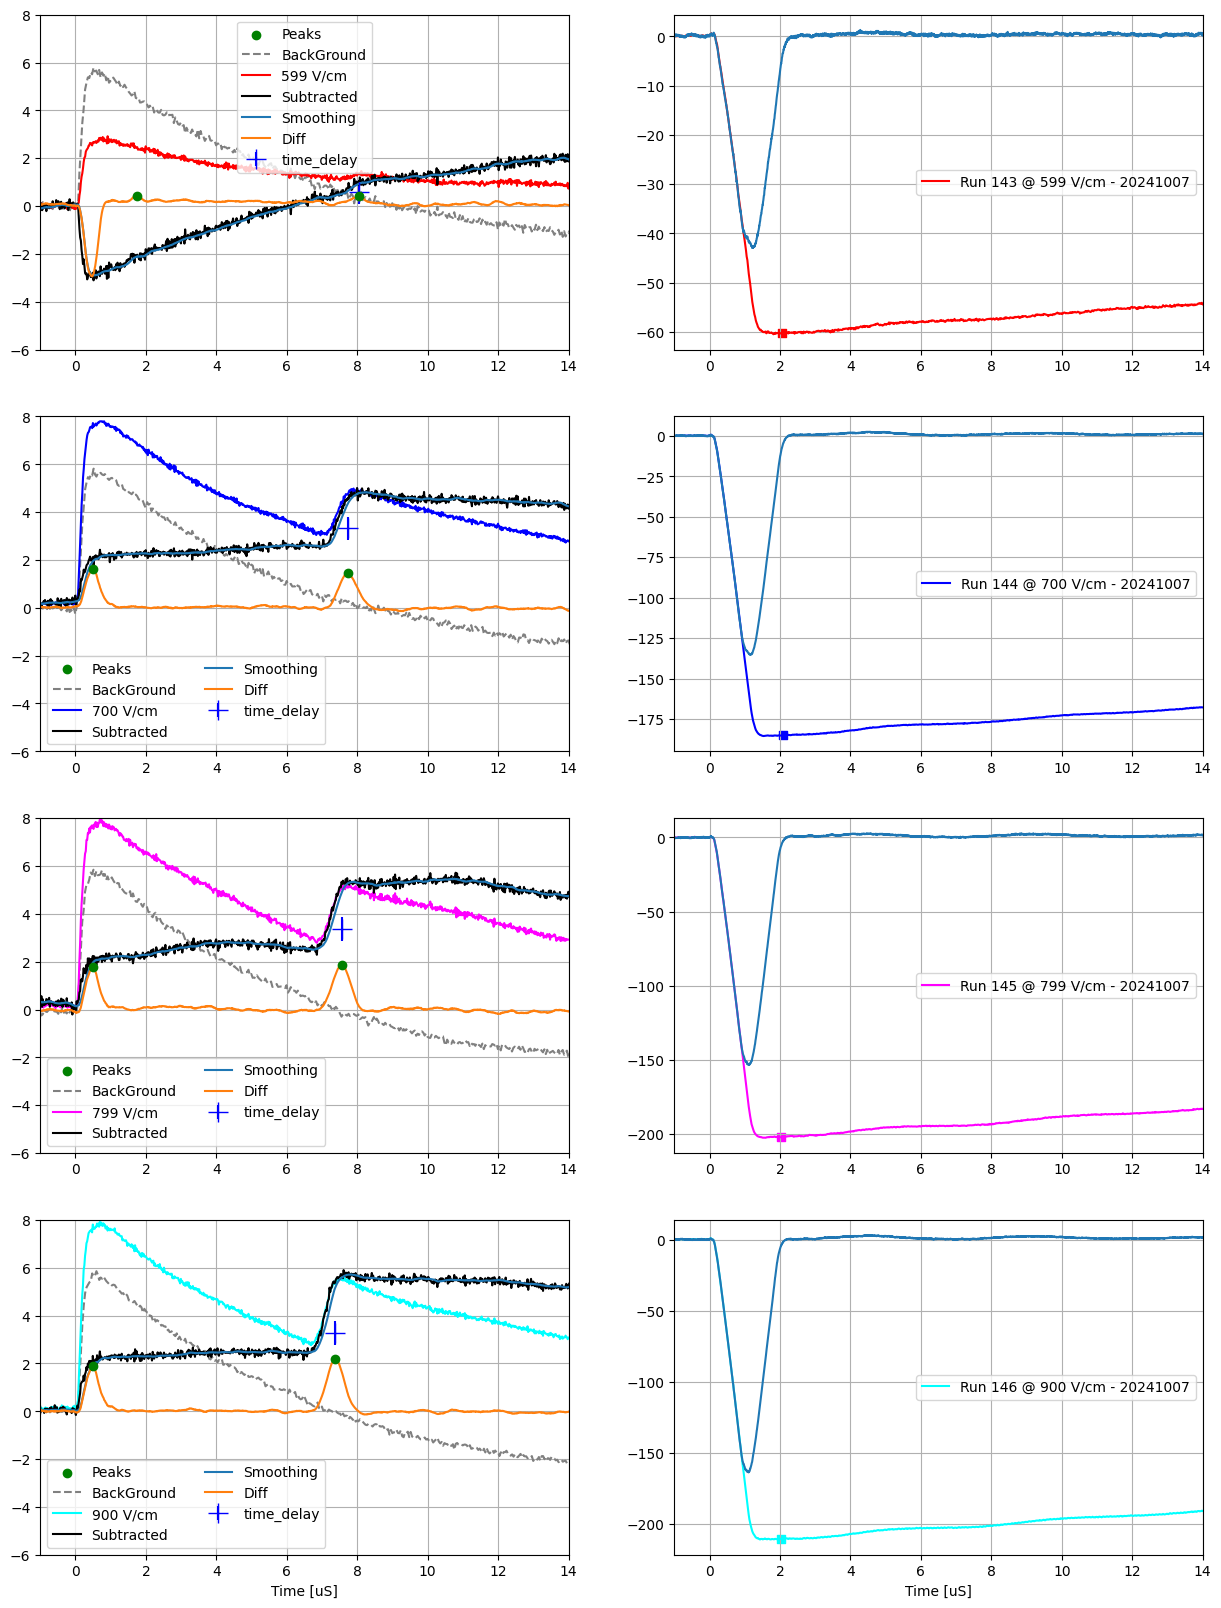

In [262]:

wafeform_path="C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/" # Path for data On left pc

dates =     [20241007,20241007,20241007]
runnumbers= [143     ,144  ,145, 146,]#147]
labels=[400,500,500,400,400,500,600,700]
bg_runs = [160,159,158,157]
c=["red","blue","magenta","cyan","brown","grey","skyblue","teal"]

chann_names=["Avg Cathode","Avg Anode"]

anode_time_delay=[]
catho_delay=[]
drift_field_list=[]
fig, axs = plt.subplots(len(runnumbers), 2,figsize=(15,20))


for i,rn  in enumerate(runnumbers):
    
    RI = GetRunInfo(rn)
    
    waveform_date ="%i"%(RI["Date"].iloc[0])
    runnumber="00%i"%(rn)
    stepcount=5
    waveform_dir=wafeform_path+waveform_date+"/"+waveform_date+"-"+runnumber
    waveform_wavenumber="10"
    waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
    waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
    DF=pd.read_csv(waveform_fullpath,skiprows=[1])
    


    ###Background

    bg_runnumber="00%i"%(bg_runs[i])
    BG_dir =wafeform_path +waveform_date+"/"+waveform_date+"-"+bg_runnumber
    bg_filename=waveform_date+"-"+bg_runnumber+"_"+waveform_wavenumber
    bg_fullpath= BG_dir + "/"+bg_filename + ".csv"
    bgDF=pd.read_csv(bg_fullpath,skiprows=[1])
    bg_anodenorm=np.average(bgDF[chann_names[1]][:100])
    ####



    drift_field = RI["Cathode Grid V."].iloc[0]/(9.14/10)
    #print(drift_field)

    anodenorm=np.average(DF[chann_names[1]][:100])
    cathnorm=np.average(DF[chann_names[0]][:100])

    bg_norm=1# np.max(DF[chann_names[1]][::stepcount] - anodenorm) / np.max(bgDF[chann_names[1]][::stepcount*2] - bg_anodenorm)



    bg_y=(bgDF[chann_names[1]]- bg_anodenorm)*bg_norm


    sub = (DF[chann_names[1]] - anodenorm) - bg_y
    
    ##BG
    axs[i][0].errorbar(x=bgDF["Time"][::stepcount*2], fmt="--",
        y=(bgDF[chann_names[1]][::stepcount*2] - bg_anodenorm)*bg_norm, 
        color="grey", label="BackGround")
    ##

    axs[i][0].errorbar(x=DF["Time"][::stepcount],y=DF[chann_names[1]][::stepcount] - anodenorm, color= c[i], label="%i V/cm "%(drift_field))
    
    #axs[1].errorbar(x=DF["Time"][::stepcount],y=DF["average(Cathode)"][::stepcount] - cathnorm, color= c[i], label="%i V/cm"%(labels[i]))
    
    ## Plot subtracted version
    axs[i][0].errorbar(x = DF["Time"][::stepcount],y=sub[::stepcount] , color="black", label="Subtracted")

    

    stepsize=50
    diffsize=100

    xdata=np.array(DF["Time"])
    ydata= sub                 #DF[chann_names[1]]-np.average(DF[chann_names[1]][:20])
    yrolling= sub.rolling(stepsize).mean()              #ydata.rolling(stepsize).mean()
    yprime=np.array(yrolling.diff(diffsize))
    ydata_nparray=np.array(np.roll(ydata,diffsize))
    



    local_minima_indices = argrelextrema(np.array(yprime), np.greater,order=1050)
    #local_minima_indices = argrelextrema(np.array(yprime), np.less,order=350)

    #print(local_minima_indices)
    # Get the x and y values of the local minima
    x_minima = xdata[local_minima_indices]
    y_minima = yprime[local_minima_indices]
    axs[i][0].scatter(x_minima, y_minima, color='green', label='Peaks', zorder=5)
    axs[i][0].errorbar(xdata,yrolling,label="Smoothing")
    axs[i][0].errorbar(xdata,yprime,label="Diff")
    
    ydata_minima = ydata_nparray[local_minima_indices[0][0]]
    #axs[i].scatter(x_minima[1], ydata_minima, color=c[i])
    
    time_delay_ind=0
    time_delay=xdata[np.array(local_minima_indices)[0][0]]
    while time_delay <3.5 :
        time_delay_ind=1 +time_delay_ind
        time_delay=xdata[np.array(local_minima_indices)[0][time_delay_ind]]
        if time_delay_ind > len(np.array(local_minima_indices)[0]) -1:
            print("Breaking out of while loop")
            break
        

    print("Run %s"%(runnumber), "  Field %f"%(drift_field) , " time Delay ",xdata[np.array(local_minima_indices)[0][time_delay_ind]] )


    anode_time_delay.append(xdata[np.array(local_minima_indices)[0][time_delay_ind]])
    ydata_minima = ydata_nparray[local_minima_indices[0][time_delay_ind]]


    #print( x_minima[time_delay_ind], ydata_minima )
    axs[i][0].errorbar(x_minima[time_delay_ind], ydata_minima,yerr=0.5, markersize=15,
                       fmt=" ", marker="+", color="blue", label="time_delay")



    axs[i][0].grid()
    axs[i][0].legend()

##cathods

    axs[i][1].errorbar(x=DF["Time"][::stepcount],y=DF[chann_names[0]][::stepcount] - cathnorm, color= c[i], label="Run %i @ %i V/cm - %s"%(rn, drift_field,waveform_date))
    axs[i][1].grid()
    axs[i][1].legend()

    Time=np.array(DF["Time"])
    Cath =DF[chann_names[0]] - cathnorm
    diff = Cath.diff(200)

    axs[i][1].errorbar(Time,diff,label="Diff")


    #cond= np.abs(diff)== np.max(np.abs(diff))
    cond= np.abs(diff)>=5


    print(Time[np.where(cond)][-1])
    cd=Time[np.where(cond)][-1]
    cd_amp=np.array(Cath.iloc[np.where(cond)])[-1]
    catho_delay.append(cd)
    print(cd_amp)

    axs[i][1].scatter(cd,cd_amp,marker="s",color=c[i])
    #catho_delay.append(Time[np.where(Cath == Cath_min)][0])
    #axs[i].set_xlim(-1,3)
    drift_field_list.append(drift_field)
    print(i)
    axs[i][0].legend(ncol=2)

    axs[i][1].set_xlim(-1,14)

    axs[i][0].set_xlim(-1,14)
    axs[i][0].set_ylim(-6,8)

axs[i][1].set_xlabel("Time [uS]")




print("cath")
print(catho_delay)
print("anode")
print(anode_time_delay)

Drift_time=np.array(anode_time_delay)-np.array(catho_delay)

print("Drift time")
print(Drift_time)
print(drift_field_list)



    

#axs[0].set_xlabel("Time [uS]")
#axs[0].set_ylabel("Preamp Signal [mV]")

#axs[0].grid()
axs[0][0].legend()


axs[i][0].set_xlabel("Time [uS]")
#axs[1].set_ylabel("Preamp Signal [mV]")
#axs[1].grid()
#axs[1].legend()

    #plt.title("Signal on 20240926")
#plt.xlim(-1000,10000)
drift_time_Oct7th_v1=np.array(Drift_time)
drift_field_list_Oct7th_v1=drift_field_list

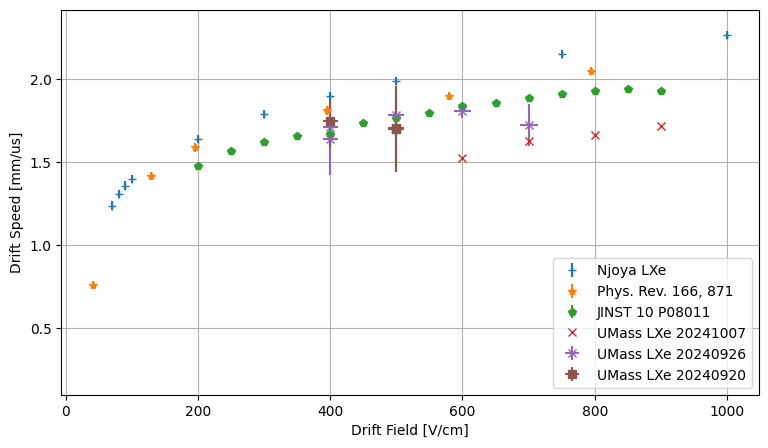

In [244]:
fig,ax= plt.subplots(1, 1, figsize=(9,5))


#print(bx)
colors=["r","blue","darkgrey","green","cyan","purple"]
marker=["o","x","p","s","h","*"]
markersize=7

sec=0

##Njoya liquid data
#njoya_y1=np.array([20,20/1.1,20/1.3,20/1.4,20/1.5,20/1.7])-1
#njoya_y2=np.array([20,20/1.1,20/1.3,20/1.4,20/1.5,20/1.7])+1
njyl=np.array([1.24,1.31,1.36,1.4,1.64,1.79,1.9,1.99,2.154,2.2685])
njxl=np.array([70,80,90,100,200,300,400,500,750,1000])
#njoya_x=[200*2,200*2,300*2,400*2,500*2,1000*2]

njoya_x=njxl
njoya_y=njyl


ax.errorbar(x=njoya_x,y=njoya_y,yerr=0.025,fmt=" ",marker="+",label="Njoya LXe")

ax.errorbar(x=ChT_Vs,y=ChT_dv,yerr=0.025,fmt=" ", marker="*",label="Phys. Rev. 166, 871 ")

ax.errorbar(x= JINST_2015_dict["Voltage"],y=JINST_2015_dict["DriftSpeed"],fmt=" ",marker="p",
            yerr=JINST_2015_dict["Error"],label="JINST 10 P08011 ")



voltages_raw=np.array(labels)

offset=[0,0,0,0]


ax.errorbar(x=drift_field_list_Oct7th_v1,
            y=9.185/drift_time_Oct7th_v1
           # ,xerr=drift_field_error[3:]
           #,yerr=delta_v_1[3:]
           ,fmt=" ",marker="x",label="UMass LXe 20241007")



ax.errorbar(x=voltages_raw[3:]+offset[3:],y=9.14/drift_time_LXe_Sept[3:]
            ,xerr=drift_field_error[3:]
           ,yerr=delta_v_1[3:],fmt=" ",marker="x",label="UMass LXe 20240926")
ax.errorbar(x=voltages_raw[:3] +offset[:3],y=9.14/drift_time_LXe_Sept[:3]
           ,xerr=drift_field_error[:3]
           ,yerr=delta_v_1[:3],fmt=" ",marker="s",label="UMass LXe 20240920")

ax.set_ylabel("Drift Speed [mm/us]")
ax.set_xlabel("Drift Field [V/cm]")


ax.set_ylim(0.1,2.42)
ax.grid()
ax.legend()

## Example back ground subtraction

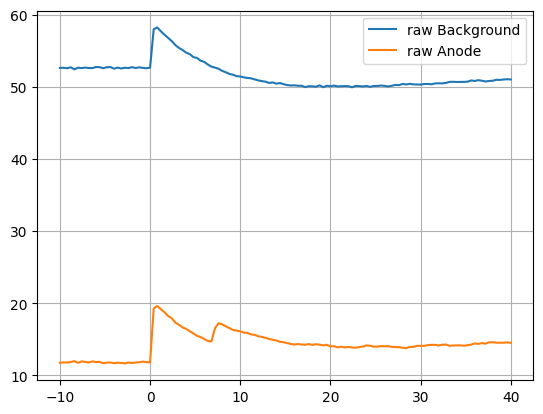

In [122]:
plt.errorbar(bgDF["Time"][::100], y=bgDF["Avg Anode"][::100],label="raw Background")
plt.errorbar(DF["Time"][::100], y=DF["Avg Anode"][::100], label="raw Anode")
plt.legend()
plt.grid()


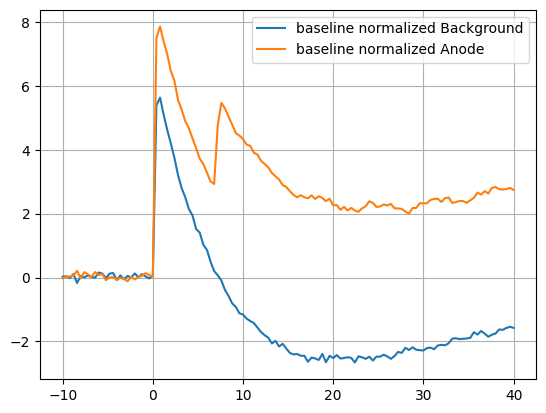

In [124]:
plt.errorbar(bgDF["Time"][::100], y=bgDF["Avg Anode"][::100]-np.average(bgDF["Avg Anode"][:100]),label="baseline normalized Background")
plt.errorbar(DF["Time"][::100], y=DF["Avg Anode"][::100]-np.average(DF["Avg Anode"][:100]), label="baseline normalized Anode")
plt.legend()
plt.grid()

0.5999999799999998
(array([2655, 4346, 6601, 8380], dtype=int64),)


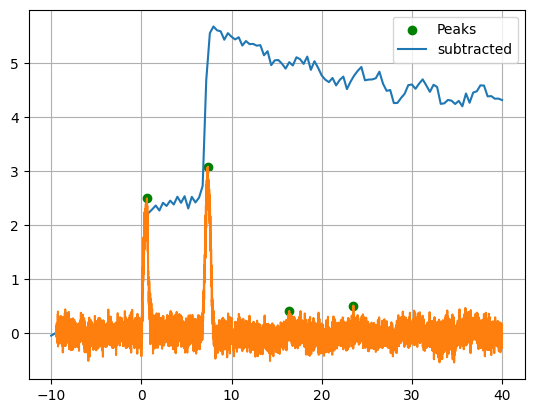

In [197]:
sub=(DF["Avg Anode"]-np.average(DF["Avg Anode"][:100]))-(bgDF["Avg Anode"]-np.average(bgDF["Avg Anode"][:100]))
diff = sub.diff(150)


print(bgDF["Time"].iloc[150] - bgDF["Time"].iloc[0])
plt.errorbar(bgDF["Time"][::100], y=sub[::100],label="subtracted")
plt.errorbar(bgDF["Time"],diff[1:])


local_minima_indices = argrelextrema(np.array(diff), np.greater,order=1500)
print(local_minima_indices)
x_minima = np.array(bgDF["Time"])[local_minima_indices]
y_minima = np.array(diff)[local_minima_indices]
plt.scatter(x_minima, y_minima, color='green', label='Peaks')

plt.legend()
plt.grid()

## Runs 151,152

Run 00151   Field 435.492651  time Delay  8.48114267
2.44514284
-32.226444799999996
0
Run 00152   Field 435.492651  time Delay  8.62199981
2.19399999
-137.0728187
1
cath
[2.44514284, 2.19399999]
anode
[8.48114267, 8.62199981]
Drift time
[6.03599983 6.42799982]
[435.4926510615133, 435.4926510615133]


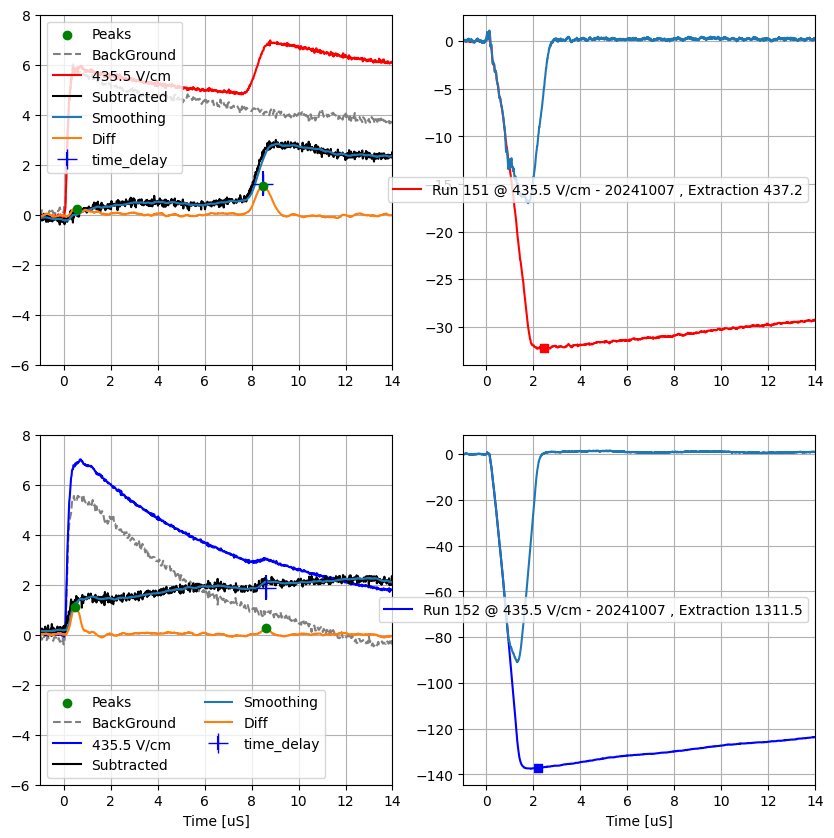

In [267]:

wafeform_path="C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/" # Path for data On left pc

dates =     [20241007,20241007,20241007]
runnumbers= [151,152]
labels=[400,500,500,400,400,500,600,700]
bg_runs = [161,162]
c=["red","blue","magenta","cyan","brown","grey","skyblue","teal"]

chann_names=["Avg Cathode","Avg Anode"]

anode_time_delay=[]
catho_delay=[]
drift_field_list=[]
fig, axs = plt.subplots(len(runnumbers), 2,figsize=(10,10))


for i,rn  in enumerate(runnumbers):
    
    RI = GetRunInfo(rn)
    
    waveform_date ="%i"%(RI["Date"].iloc[0])
    runnumber="00%i"%(rn)
    stepcount=5
    waveform_dir=wafeform_path+waveform_date+"/"+waveform_date+"-"+runnumber
    waveform_wavenumber="10"
    waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
    waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
    DF=pd.read_csv(waveform_fullpath,skiprows=[1])
    


    ###Background

    bg_runnumber="00%i"%(bg_runs[i])
    BG_dir =wafeform_path +waveform_date+"/"+waveform_date+"-"+bg_runnumber
    bg_filename=waveform_date+"-"+bg_runnumber+"_"+waveform_wavenumber
    bg_fullpath= BG_dir + "/"+bg_filename + ".csv"
    bgDF=pd.read_csv(bg_fullpath,skiprows=[1])
    bg_anodenorm=np.average(bgDF[chann_names[1]][:100])
    ####



    drift_field = RI["Drift Field"].iloc[0]#RI["Cathode Grid V."].iloc[0]/(9.14/10)
    extract_field=RI["Extraction Field"].iloc[0]


    #print(drift_field)

    anodenorm=np.average(DF[chann_names[1]][:100])
    cathnorm=np.average(DF[chann_names[0]][:100])

    bg_norm=1# np.max(DF[chann_names[1]][::stepcount] - anodenorm) / np.max(bgDF[chann_names[1]][::stepcount*2] - bg_anodenorm)



    bg_y=(bgDF[chann_names[1]]- bg_anodenorm)*bg_norm


    sub = (DF[chann_names[1]] - anodenorm) - bg_y
    
    ##BG
    axs[i][0].errorbar(x=bgDF["Time"][::stepcount*2], fmt="--",
        y=(bgDF[chann_names[1]][::stepcount*2] - bg_anodenorm)*bg_norm, 
        color="grey", label="BackGround")
    ##

    axs[i][0].errorbar(x=DF["Time"][::stepcount],y=DF[chann_names[1]][::stepcount] - anodenorm, color= c[i], label="%0.1f V/cm "%(drift_field))
    
    #axs[1].errorbar(x=DF["Time"][::stepcount],y=DF["average(Cathode)"][::stepcount] - cathnorm, color= c[i], label="%i V/cm"%(labels[i]))
    
    ## Plot subtracted version
    axs[i][0].errorbar(x = DF["Time"][::stepcount],y=sub[::stepcount] , color="black", label="Subtracted")

    

    stepsize=50
    diffsize=100

    xdata=np.array(DF["Time"])
    ydata= sub                 #DF[chann_names[1]]-np.average(DF[chann_names[1]][:20])
    yrolling= sub.rolling(stepsize).mean()              #ydata.rolling(stepsize).mean()
    yprime=np.array(yrolling.diff(diffsize))
    ydata_nparray=np.array(np.roll(ydata,diffsize))



    local_minima_indices = argrelextrema(np.array(yprime), np.greater,order=1050)
    #local_minima_indices = argrelextrema(np.array(yprime), np.less,order=350)

    #print(local_minima_indices)
    # Get the x and y values of the local minima
    x_minima = xdata[local_minima_indices]
    y_minima = yprime[local_minima_indices]
    axs[i][0].scatter(x_minima, y_minima, color='green', label='Peaks', zorder=5)
    axs[i][0].errorbar(xdata,yrolling,label="Smoothing")
    axs[i][0].errorbar(xdata,yprime,label="Diff")
    
    ydata_minima = ydata_nparray[local_minima_indices[0][0]]
    #axs[i].scatter(x_minima[1], ydata_minima, color=c[i])
    
    time_delay_ind=0
    time_delay=xdata[np.array(local_minima_indices)[0][0]]
    while time_delay <3.5 :
        time_delay_ind=1 +time_delay_ind
        time_delay=xdata[np.array(local_minima_indices)[0][time_delay_ind]]
        if time_delay_ind > len(np.array(local_minima_indices)[0]) -1:
            print("Breaking out of while loop")
            break
        

    print("Run %s"%(runnumber), "  Field %f"%(drift_field) , " time Delay ",xdata[np.array(local_minima_indices)[0][time_delay_ind]] )


    anode_time_delay.append(xdata[np.array(local_minima_indices)[0][time_delay_ind]])
    ydata_minima = ydata_nparray[local_minima_indices[0][time_delay_ind]]


    #print( x_minima[time_delay_ind], ydata_minima )
    axs[i][0].errorbar(x_minima[time_delay_ind], ydata_minima,yerr=0.5, markersize=15,
                       fmt=" ", marker="+", color="blue", label="time_delay")



    axs[i][0].grid()
    axs[i][0].legend()

##cathods

    axs[i][1].errorbar(x=DF["Time"][::stepcount],y=DF[chann_names[0]][::stepcount] - cathnorm, color= c[i]
                       , label="Run %i @ %0.1f V/cm - %s , Extraction %0.1f"%(rn, drift_field,waveform_date,extract_field))
    axs[i][1].grid()
    axs[i][1].legend()

    Time=np.array(DF["Time"])
    Cath =DF[chann_names[0]] - cathnorm
    diff = Cath.diff(200)

    axs[i][1].errorbar(Time,diff,label="Diff")


    #cond= np.abs(diff)== np.max(np.abs(diff))
    cond= np.abs(diff)>=5


    print(Time[np.where(cond)][-1])
    cd=Time[np.where(cond)][-1]
    cd_amp=np.array(Cath.iloc[np.where(cond)])[-1]
    catho_delay.append(cd)
    print(cd_amp)

    axs[i][1].scatter(cd,cd_amp,marker="s",color=c[i])
    #catho_delay.append(Time[np.where(Cath == Cath_min)][0])
    #axs[i].set_xlim(-1,3)
    drift_field_list.append(drift_field)
    print(i)
    axs[i][0].legend(ncol=2)

    axs[i][1].set_xlim(-1,14)

    axs[i][0].set_xlim(-1,14)
    axs[i][0].set_ylim(-6,8)

axs[i][1].set_xlabel("Time [uS]")




print("cath")
print(catho_delay)
print("anode")
print(anode_time_delay)

Drift_time=np.array(anode_time_delay)-np.array(catho_delay)

print("Drift time")
print(Drift_time)
print(drift_field_list)



    

#axs[0].set_xlabel("Time [uS]")
#axs[0].set_ylabel("Preamp Signal [mV]")

#axs[0].grid()
axs[0][0].legend()


axs[i][0].set_xlabel("Time [uS]")
#axs[1].set_ylabel("Preamp Signal [mV]")
#axs[1].grid()
#axs[1].legend()

    #plt.title("Signal on 20240926")
#plt.xlim(-1000,10000)
drift_time_Oct7th_v2=np.array(Drift_time)
drift_field_list_Oct7th_v2=drift_field_list

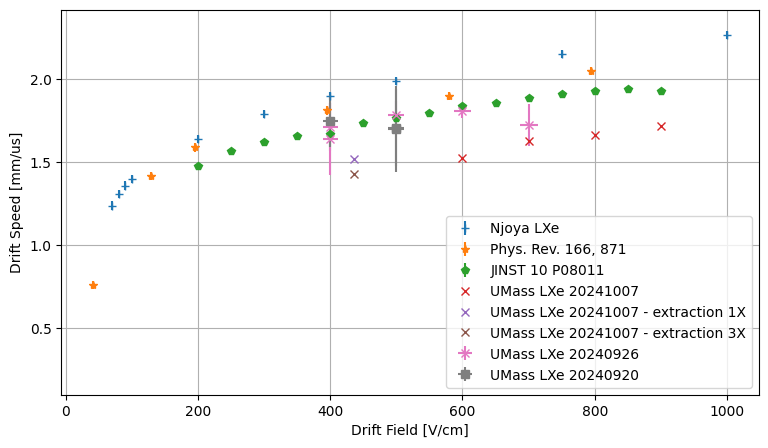

In [268]:
fig,ax= plt.subplots(1, 1, figsize=(9,5))


#print(bx)
colors=["r","blue","darkgrey","green","cyan","purple"]
marker=["o","x","p","s","h","*"]
markersize=7

sec=0

##Njoya liquid data
#njoya_y1=np.array([20,20/1.1,20/1.3,20/1.4,20/1.5,20/1.7])-1
#njoya_y2=np.array([20,20/1.1,20/1.3,20/1.4,20/1.5,20/1.7])+1
njyl=np.array([1.24,1.31,1.36,1.4,1.64,1.79,1.9,1.99,2.154,2.2685])
njxl=np.array([70,80,90,100,200,300,400,500,750,1000])
#njoya_x=[200*2,200*2,300*2,400*2,500*2,1000*2]

njoya_x=njxl
njoya_y=njyl


ax.errorbar(x=njoya_x,y=njoya_y,yerr=0.025,fmt=" ",marker="+",label="Njoya LXe")

ax.errorbar(x=ChT_Vs,y=ChT_dv,yerr=0.025,fmt=" ", marker="*",label="Phys. Rev. 166, 871 ")

ax.errorbar(x= JINST_2015_dict["Voltage"],y=JINST_2015_dict["DriftSpeed"],fmt=" ",marker="p",
            yerr=JINST_2015_dict["Error"],label="JINST 10 P08011 ")



voltages_raw=np.array(labels)

offset=[0,0,0,0]


ax.errorbar(x=drift_field_list_Oct7th_v1,
            y=9.185/drift_time_Oct7th_v1
           # ,xerr=drift_field_error[3:]
           #,yerr=delta_v_1[3:]
           ,fmt=" ",marker="x",label="UMass LXe 20241007")


ax.errorbar(x=drift_field_list_Oct7th_v2[:1],
            y=9.185/drift_time_Oct7th_v2[:1]
           # ,xerr=drift_field_error[3:]
           #,yerr=delta_v_1[3:]
           ,fmt=" ",marker="x",label="UMass LXe 20241007 - extraction 1X")
ax.errorbar(x=drift_field_list_Oct7th_v2[1:],
            y=9.185/drift_time_Oct7th_v2[1:]
           # ,xerr=drift_field_error[3:]
           #,yerr=delta_v_1[3:]
           ,fmt=" ",marker="x",label="UMass LXe 20241007 - extraction 3X")




ax.errorbar(x=voltages_raw[3:]+offset[3:],y=9.14/drift_time_LXe_Sept[3:]
            ,xerr=drift_field_error[3:]
           ,yerr=delta_v_1[3:],fmt=" ",marker="x",label="UMass LXe 20240926")
ax.errorbar(x=voltages_raw[:3] +offset[:3],y=9.14/drift_time_LXe_Sept[:3]
           ,xerr=drift_field_error[:3]
           ,yerr=delta_v_1[:3],fmt=" ",marker="s",label="UMass LXe 20240920")

ax.set_ylabel("Drift Speed [mm/us]")
ax.set_xlabel("Drift Field [V/cm]")


ax.set_ylim(0.1,2.42)
ax.grid()
ax.legend()

154
12502 12503
Not equal
Run 00154   Field 1088.731628  time Delay  7.52133317
2.04933333
0



153
12502 12502
Run 00153   Field 1088.731628  time Delay  7.57599984
2.30799999
1



156
12502 12502
Run 00156   Field 1088.731628  time Delay  7.67333317
2.47733332
2



cath
[2.04933333, 2.30799999, 2.47733332]
anode
[7.52133317, 7.57599984, 7.67333317]
Drift time
[5.47199984 5.26799985 5.19599985]
[1088.7316276537833, 1088.7316276537833, 1088.7316276537833]


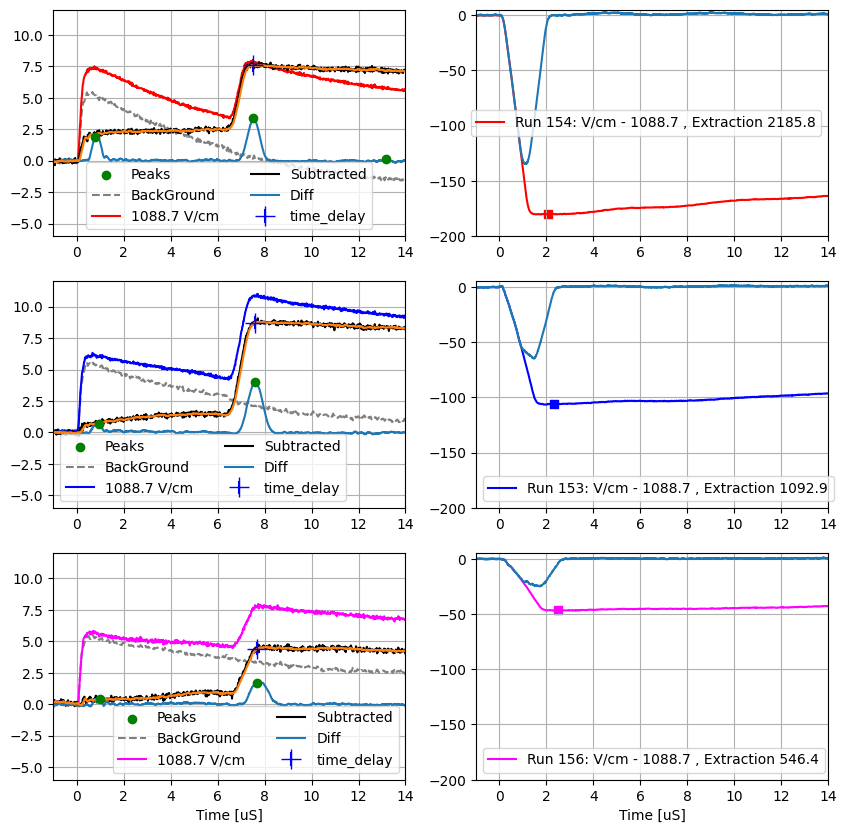

In [330]:

wafeform_path="C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/" # Path for data On left pc

dates =     [20241007,20241007,20241007]
runnumbers= [154,153,156]
labels=[400,500,500,400,400,500,600,700]
bg_runs = [164,163,166]
c=["red","blue","magenta","cyan","brown","grey","skyblue","teal"]

chann_names=["Avg Cathode","Avg Anode"]

anode_time_delay=[]
catho_delay=[]
drift_field_list=[]
fig, axs = plt.subplots(len(runnumbers), 2,figsize=(10,10))


for i,rn  in enumerate(runnumbers):
    
    RI = GetRunInfo(rn)
    
    waveform_date ="%i"%(RI["Date"].iloc[0])
    runnumber="00%i"%(rn)
    stepcount=5
    waveform_dir=wafeform_path+waveform_date+"/"+waveform_date+"-"+runnumber
    waveform_wavenumber="10"
    waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
    waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
    DF=pd.read_csv(waveform_fullpath,skiprows=[1])
    
    print(rn)

    ###Background

    bg_runnumber="00%i"%(bg_runs[i])
    BG_dir =wafeform_path +waveform_date+"/"+waveform_date+"-"+bg_runnumber
    bg_filename=waveform_date+"-"+bg_runnumber+"_"+waveform_wavenumber
    bg_fullpath= BG_dir + "/"+bg_filename + ".csv"
    bgDF=pd.read_csv(bg_fullpath,skiprows=[1])
    bg_anodenorm=np.average(bgDF[chann_names[1]][:100])
    ####



    drift_field = RI["Drift Field"].iloc[0]#RI["Cathode Grid V."].iloc[0]/(9.14/10)
    extract_field=RI["Extraction Field"].iloc[0]


    #print(drift_field)

    anodenorm=np.average(DF[chann_names[1]][:100])
    cathnorm=np.average(DF[chann_names[0]][:100])

    bg_norm=1# np.max(DF[chann_names[1]][::stepcount] - anodenorm) / np.max(bgDF[chann_names[1]][::stepcount*2] - bg_anodenorm)



    bg_y=(bgDF[chann_names[1]]- bg_anodenorm)*bg_norm


    sub = (DF[chann_names[1]] - anodenorm) - bg_y
    
    ##BG
    axs[i][0].errorbar(x=bgDF["Time"][::stepcount*2], fmt="--",
        y=(bgDF[chann_names[1]][::stepcount*2] - bg_anodenorm)*bg_norm, 
        color="grey", label="BackGround")
    ##

    axs[i][0].errorbar(x=DF["Time"][::stepcount],y=DF[chann_names[1]][::stepcount] - anodenorm, color= c[i], label="%0.1f V/cm "%(drift_field))
    
    #axs[1].errorbar(x=DF["Time"][::stepcount],y=DF["average(Cathode)"][::stepcount] - cathnorm, color= c[i], label="%i V/cm"%(labels[i]))
    
    ## Plot subtracted version
    axs[i][0].errorbar(x = DF["Time"][::stepcount],y=sub[::stepcount] , color="black", label="Subtracted")

    

    stepsize=25
    diffsize=100

    xdata=np.array(DF["Time"])
    ydata= sub                 #DF[chann_names[1]]-np.average(DF[chann_names[1]][:20])
    yrolling= sub.rolling(stepsize).mean()              #ydata.rolling(stepsize).mean()
    yprime=np.roll(np.array(yrolling.diff(diffsize)),diffsize)
    ydata_nparray=np.array(ydata)



    local_minima_indices = argrelextrema(np.array(yprime), np.greater,order=1050)
    #local_minima_indices = argrelextrema(np.array(yprime), np.less,order=350)

    #print(local_minima_indices)
    # Get the x and y values of the local minima
    x_minima = xdata[local_minima_indices]
    y_minima = yprime[local_minima_indices]
    axs[i][0].scatter(x_minima, y_minima, color='green', label='Peaks', zorder=5)


    print(len(xdata),len(yprime))

    if len(xdata) == len(yprime):
        axs[i][0].errorbar(xdata,yprime,label="Diff")
        axs[i][0].errorbar(xdata,yrolling)#,label="Smoothing")
    else :
        print("Not equal")
        max_ind= int(np.min([len(xdata),len(yprime)]))
        axs[i][0].errorbar(xdata[:max_ind],yprime[:max_ind],label="Diff")
        axs[i][0].errorbar(xdata[:max_ind],yrolling[:max_ind])#,label="Smoothing")
    
    
    ydata_minima = ydata_nparray[local_minima_indices[0][0]]
    #axs[i].scatter(x_minima[1], ydata_minima, color=c[i])
    
    time_delay_ind=0
    time_delay=xdata[np.array(local_minima_indices)[0][0]]
    while time_delay <3.5 :
        time_delay_ind=1 +time_delay_ind
        time_delay=xdata[np.array(local_minima_indices)[0][time_delay_ind]]
        if time_delay_ind > len(np.array(local_minima_indices)[0]) -1:
            print("Breaking out of while loop")
            break
        

    print("Run %s"%(runnumber), "  Field %f"%(drift_field) , " time Delay ",xdata[np.array(local_minima_indices)[0][time_delay_ind]] )


    anode_time_delay.append(xdata[np.array(local_minima_indices)[0][time_delay_ind]])
    ydata_minima = ydata_nparray[local_minima_indices[0][time_delay_ind]]


    #print( x_minima[time_delay_ind], ydata_minima )
    axs[i][0].errorbar(x_minima[time_delay_ind], ydata_minima,yerr=0.5, markersize=15,
                       fmt=" ", marker="+", color="blue", label="time_delay")



    axs[i][0].grid()
    axs[i][0].legend()

##cathods

    axs[i][1].errorbar(x=DF["Time"][::stepcount],y=DF[chann_names[0]][::stepcount] - cathnorm, color= c[i]
                       , label="Run %i: V/cm - %0.1f , Extraction %0.1f"%(rn, drift_field,extract_field))
    axs[i][1].grid()
    axs[i][1].legend()

    Time=np.array(DF["Time"])
    Cath =DF[chann_names[0]] - cathnorm
    diff = Cath.diff(200)

    axs[i][1].errorbar(Time,diff,label="Diff")


    #cond= np.abs(diff)== np.max(np.abs(diff))
    cond= np.abs(diff)>=5


    print(Time[np.where(cond)][-1])
    cd=Time[np.where(cond)][-1]
    cd_amp=np.array(Cath.iloc[np.where(cond)])[-1]
    catho_delay.append(cd)
    

    axs[i][1].scatter(cd,cd_amp,marker="s",color=c[i])
    #catho_delay.append(Time[np.where(Cath == Cath_min)][0])
    #axs[i].set_xlim(-1,3)
    drift_field_list.append(drift_field)
    print(i)
    axs[i][0].legend(ncol=2)

    axs[i][1].set_xlim(-1,14)

    axs[i][0].set_xlim(-1,14)
    axs[i][0].set_ylim(-6,12)

    axs[i][1].set_ylim(-200,5)

    print("\n\n")

axs[i][1].set_xlabel("Time [uS]")




print("cath")
print(catho_delay)
print("anode")
print(anode_time_delay)

Drift_time=np.array(anode_time_delay)-np.array(catho_delay)

print("Drift time")
print(Drift_time)
print(drift_field_list)



    

#axs[0].set_xlabel("Time [uS]")
#axs[0].set_ylabel("Preamp Signal [mV]")

#axs[0].grid()
#axs[0][0].set_ylim(-5,8)


axs[i][0].set_xlabel("Time [uS]")
#axs[1].set_ylabel("Preamp Signal [mV]")
#axs[1].grid()
#axs[1].legend()

    #plt.title("Signal on 20240926")
#plt.xlim(-1000,10000)
drift_time_Oct7th_v3=np.array(Drift_time)
drift_field_list_Oct7th_v3=drift_field_list

In [331]:
xdata[100]-xdata[0]

0.39999998999999953

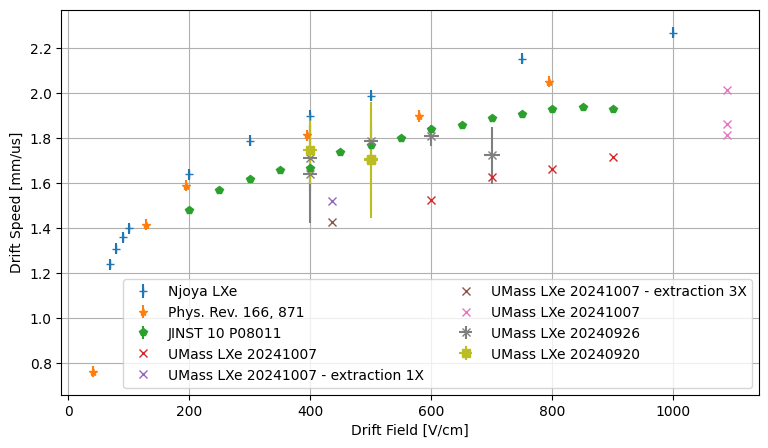

In [328]:
fig,ax= plt.subplots(1, 1, figsize=(9,5))


#print(bx)
colors=["r","blue","darkgrey","green","cyan","purple"]
marker=["o","x","p","s","h","*"]
markersize=7

sec=0

##Njoya liquid data
#njoya_y1=np.array([20,20/1.1,20/1.3,20/1.4,20/1.5,20/1.7])-1
#njoya_y2=np.array([20,20/1.1,20/1.3,20/1.4,20/1.5,20/1.7])+1
njyl=np.array([1.24,1.31,1.36,1.4,1.64,1.79,1.9,1.99,2.154,2.2685])
njxl=np.array([70,80,90,100,200,300,400,500,750,1000])
#njoya_x=[200*2,200*2,300*2,400*2,500*2,1000*2]

njoya_x=njxl
njoya_y=njyl


ax.errorbar(x=njoya_x,y=njoya_y,yerr=0.025,fmt=" ",marker="+",label="Njoya LXe")

ax.errorbar(x=ChT_Vs,y=ChT_dv,yerr=0.025,fmt=" ", marker="*",label="Phys. Rev. 166, 871 ")

ax.errorbar(x= JINST_2015_dict["Voltage"],y=JINST_2015_dict["DriftSpeed"],fmt=" ",marker="p",
            yerr=JINST_2015_dict["Error"],label="JINST 10 P08011 ")



voltages_raw=np.array(labels)

offset=[0,0,0,0]


ax.errorbar(x=drift_field_list_Oct7th_v1,
            y=9.185/drift_time_Oct7th_v1
           # ,xerr=drift_field_error[3:]
           #,yerr=delta_v_1[3:]
           ,fmt=" ",marker="x",label="UMass LXe 20241007")


ax.errorbar(x=drift_field_list_Oct7th_v2[:1],
            y=9.185/drift_time_Oct7th_v2[:1]
           # ,xerr=drift_field_error[3:]
           #,yerr=delta_v_1[3:]
           ,fmt=" ",marker="x",label="UMass LXe 20241007 - extraction 1X")
ax.errorbar(x=drift_field_list_Oct7th_v2[1:],
            y=9.185/drift_time_Oct7th_v2[1:]
           # ,xerr=drift_field_error[3:]
           #,yerr=delta_v_1[3:]
           ,fmt=" ",marker="x",label="UMass LXe 20241007 - extraction 3X")



ax.errorbar(x=drift_field_list_Oct7th_v3,
            y=9.185/drift_time_Oct7th_v3
           # ,xerr=drift_field_error[3:]
           #,yerr=delta_v_1[3:]
           ,fmt=" ",marker="x",label="UMass LXe 20241007")




ax.errorbar(x=voltages_raw[3:]+offset[3:],y=9.14/drift_time_LXe_Sept[3:]
            ,xerr=drift_field_error[3:]
           ,yerr=delta_v_1[3:],fmt=" ",marker="x",label="UMass LXe 20240926")
ax.errorbar(x=voltages_raw[:3] +offset[:3],y=9.14/drift_time_LXe_Sept[:3]
           ,xerr=drift_field_error[:3]
           ,yerr=delta_v_1[:3],fmt=" ",marker="s",label="UMass LXe 20240920")

ax.set_ylabel("Drift Speed [mm/us]")
ax.set_xlabel("Drift Field [V/cm]")


#ax.set_ylim(0.1,2.42)
ax.grid()
ax.legend(ncol=2)

In [311]:
mu_e=(( (9.185/1000) /(drift_time_Oct7th_v3*10**(-6))) / drift_field_list_Oct7th_v3*100 ) #[mm^2/(V*s)]
e_ch= 1.602E-19 #[C]
e_mass =9.109E-31 #[kg]

Tau= e_mass/(e_ch*mu_e) * 10**(9) #[us]
Tau

array([3.72308993e-05, 3.60716461e-05, 3.66917117e-05])

In [303]:
mu_e

array([254.81549788, 232.24731757, 208.20144268, 190.97222758])

In [300]:
( (9.185/1000) /(drift_time_Oct7th_v1*10**(-6))) 


array([1527.77782098, 1626.23942284, 1665.15595838, 1718.75004824])